In [1]:
#!pip uninstall tensorflow

In [2]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
from tensorflow.compat.v1 import enable_eager_execution
import tensorflow as tf
import numpy as np
import os
import tensorflow_probability as tfp
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

## 匯入資料（MNIST）

## 參數設定

In [3]:
img_size = 28
flatten_size = img_size * img_size 

regular = 1e-5

z_dim = 32
h_dim = [8, 4]
objective = 'deep-SVDD'     #'  'soft-boundary'


## 建構模型

## Prtrain

In [4]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = 28, z_dim = 32, h_dim = [8, 4]):
        
        self.label_num = label_num
        self.img_size = img_size
        self.flatten_size = img_size * img_size
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.5e-3)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, self.img_size, self.img_size, 1))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)    
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.keras.layers.Dense(self.h_dim[1] * 7 * 7,  use_bias = False)(inputs)
        x = tf.reshape(x, shape = (-1, 7, 7, self.h_dim[1]))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 

        x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)

        x = tf.reshape(x, shape = (-1, self.flatten_size))
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone = 50):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoint/mnist_classAE_label_{}' .format(
            self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

## 匯入資料

In [5]:
def load_data(label_num, outlier_nu):

    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') /255.
    x_test = x_test.astype('float32') /255.
    
    random.seed (1120)
    normal_n = sum(y_train == label_num)
    outlier_n = sum(y_train != label_num)
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    
    x_train = np.vstack( (x_train[y_train==label_num], x_train[y_train!=label_num][indices]))
    y_train = np.hstack( (y_train[y_train==label_num], y_train[y_train!=label_num][indices]))

    # Flatten the dataset
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))


    return  x_train, y_train, x_test, y_test

In [6]:
def split_data(x_train, y_train, batch_size = 200):
    x_novali, x_vali, y_novali, y_vali = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    
    
    n_samples = len(x_novali)
    train_dataset = tf.data.Dataset.from_tensor_slices(x_novali)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    validation_n = len(x_vali)
    
    return train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n

## result 

In [7]:
def threshold_img(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [8]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
def false_img(data, y_test,  dists, r, label_num):
    data_n = data[y_test!=label_num]
    data_p = data[y_test==label_num]
    
    dist_n = (dists - r**2)[y_test!=label_num]
    dist_p = (dists - r**2)[y_test==label_num]
    
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    n_digits = min([len(fn),len(fp),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display fn
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display fp
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
def distance_plot(label_num, dist, radius_end, objective, name, train = True, label = None,  nu = 0.1):
    treshold = radius_end ** 2
    if train:
        plt.title(str(objective) + ' label = {} train data'.format(name))
        if objective == 'soft-boundary':
            treshold = 0
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        else:
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        plt.show()       
    
    else:
        plt.title(str(objective) + ' label = {} test data'.format(name))
        if objective == 'soft-boundary':
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
            plt.axvline(treshold,  color='g')
            plt.legend()

        else:
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(float(treshold), color='g')
            plt.legend()

        plt.legend()
        plt.show()
    


In [11]:
class train_SVDD():
    
    def __init__(self, label_num , objective , encoder, train_dataset, nu = 0.2, z_dim = 32):
        
        self.objective = objective
        self.nu = nu
        self.z_dim = z_dim
        self.encoder = encoder
        self.label_num = label_num
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3, epsilon = 1e-6)
        self.train_dataset = train_dataset
        self.center = self.init_center_c( eps = 0.1)
        if self.objective == 'soft-boundary':
            self.R = tf.zeros(shape = [1], dtype = tf.float32, name = 'R')
        else:
            self.R = None
        
        
    def init_center_c(self, eps = 0.1):
        
        self.encoder.load_weights('D:/7107018014/checkpoint/mnist_classAE_label_{}' .format(
            self.label_num))
        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        
        for batch, (batch_x) in enumerate(self.train_dataset):
            output = self.encoder(batch_x, training=False)            
            if batch ==0:
                modeloutput = output
            else:
                modeloutput = tf.concat([modeloutput, output], 0)
        
        c = tf.reduce_mean(modeloutput, axis = 0, name = 'outputs')
        #c = tf.reduce_mean( self.encoder(data, training = False), axis = 0, name = 'outputs') 

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
        
    def get_radius(self,dist, nu):
        """Optimally solve for radius R via the (1-nu)-quantile of distances."""
        return tfp.stats.percentile(tf.sqrt(dist), (1-self.nu)*100)

    def loss(self, objective, dist, R = None):

        if objective == 'soft-boundary':
            scores = dist - R**2
            avg_loss = R**2 + (1/nu) * tf.reduce_mean(tf.maximum(tf.zeros_like(scores), scores))

        if objective=='deep-SVDD':
            avg_loss = tf.reduce_mean(dist)
        return avg_loss

    @tf.function
    def train_model(self, batch_x, center, objective, R = None):
        with tf.GradientTape() as tape:
            output = self.encoder(batch_x, training=True)
            dist = tf.reduce_sum((output - self.center) ** 2, axis=1)
            output_loss = self.loss(self.objective, dist, R)

        grads = tape.gradient(output_loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables))

        return output_loss, dist
    def train(self, x_novali, n_epochs = 150, warm_up_n_epochs = 10, lr_milestone = 50):
        
        loss_list = []
        for epoch in range(n_epochs):
            epoch_loss_avg = tf.metrics.Mean()
            if (epoch+1) % lr_milestone == 0:
                self.optimizer.lr = 0.1 * self.optimizer.lr

            for batch, (batch_x) in enumerate( self.train_dataset):
                loss_, dist = self.train_model(batch_x, self.center, self.objective, self.R )
                epoch_loss_avg(loss_)
                if (self.objective == 'soft-boundary') and (epoch >= warm_up_n_epochs):
                    self.R = self.get_radius(dist, nu)
            loss_list.append(loss_)
        self.encoder.save_weights('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Model_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu))
        if (self.objective == 'soft-boundary'):
            np.save('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu), self.R.numpy())
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        
    def distance(self, data, load_model = False):
        if load_model:
            self.encoder.load_weights('D:/7107018014/checkpoint/Model_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu))
            self.R = np.load('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}.npy' .format
                                  (self.objective, self.label_num, self.nu))
        output = self.encoder(tf.convert_to_tensor(data), training=False)
        dist = tf.reduce_sum(tf.math.square(output - self.center) , axis=1) ## dist**2
        
        return dist
    
    def decide_treshold(self, x_novali):
        
        if self.objective == 'soft-boundary':
            self.R = np.load('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}.npy' .format
                                  (self.objective, self.label_num, self.nu))
            radius_end = self.R
        else:
            dis = self.distance(tf.convert_to_tensor(x_novali))
            radius_end = self.get_radius(dis, self.nu).numpy()
            
        return float(radius_end)
    
    def train_result(self, x_novali, y_novali, show_img = False, load_model = False):
        
        radius_end = self.decide_treshold(x_novali)
        test_auc = 0.
        confusionmatrix = 0.
        if show_img:
            dist = self.distance(x_novali, load_model = load_model).numpy()
            test_auc, confusionmatrix = self.result(dist, y_novali, radius_end, show_img = show_img)
            distance_plot(self.label_num, dist, radius_end, self.objective, name =  self.label_num,
                          train = True, label = y_novali, nu = self.nu )
            print(' train label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_novali, dist, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(x_train, dist)
            print('train label = {} false_img'.format(self.label_num))
            false_img(x_novali, y_novali,  dist, radius_end, self.label_num)
            
        return radius_end, test_auc, confusionmatrix
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test==self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        test_auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', test_auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return test_auc, confusionmatrix 
    
    def test(self, x_test, y_test, radius_end, show_img = False, load_model = False, search_u = False):
        
        dist = self.distance(x_test, load_model = load_model).numpy()
        test_auc, confusionmatrix = self.result(dist, y_test, radius_end, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dist, radius_end, self.objective, name =  self.label_num,
                          train = False, label = y_test, nu = self.nu )
            print('test label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_test, dist, radius_end)
            print('test label = {} distance oder'.format(self.label_num))
            threshold_img(x_test, dist)
            print('test label = {} false_img'.format(self.label_num))
            false_img(x_test, y_test,  dist, radius_end, self.label_num)
        if search_u:
            print('u = {}, auc = {}'.format(self.nu, test_auc))
        return test_auc, confusionmatrix 

## 看時間的結果

In [73]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [74]:
objective = 'deep-SVDD'
nu = 0.05
outlier_nu = 0.05
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print(label_num,'  auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)

0   auc =  0.8984639576451424
1   auc =  0.9905434180350882
2   auc =  0.820963825297872
3   auc =  0.8473783852245069
4   auc =  0.8984970769029942
5   auc =  0.8035555151830255
6   auc =  0.9259635733775897
7   auc =  0.9246900430392175
8   auc =  0.8682394142224766
9   auc =  0.9394609894554835


In [81]:
result

array([[ 0.        ,  0.        ,  0.89846396, 40.5874939 ],
       [ 1.        ,  0.        ,  0.99054342, 44.69686556],
       [ 2.        ,  0.        ,  0.82096383, 40.2468884 ],
       [ 3.        ,  0.        ,  0.84737839, 40.76389384],
       [ 4.        ,  0.        ,  0.89849708, 38.77821302],
       [ 5.        ,  0.        ,  0.80355552, 36.3908999 ],
       [ 6.        ,  0.        ,  0.92596357, 38.59728336],
       [ 7.        ,  0.        ,  0.92469004, 42.07021666],
       [ 8.        ,  0.        ,  0.86823941, 38.8217411 ],
       [ 9.        ,  0.        ,  0.93946099, 39.04745054]])

AUC: 0.942373204794753
confusion_matrix:
[[ 138  101]
 [ 112 4624]]


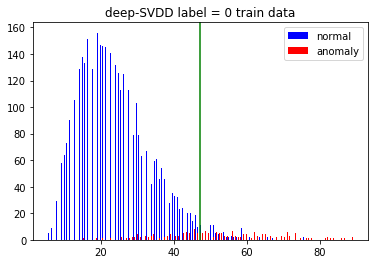

 train label = 0 uncertain_img


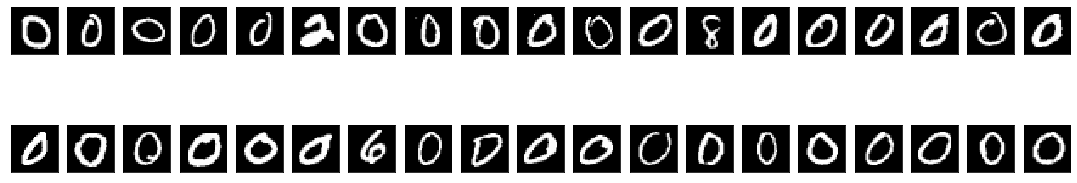

train label = 0 distance oder


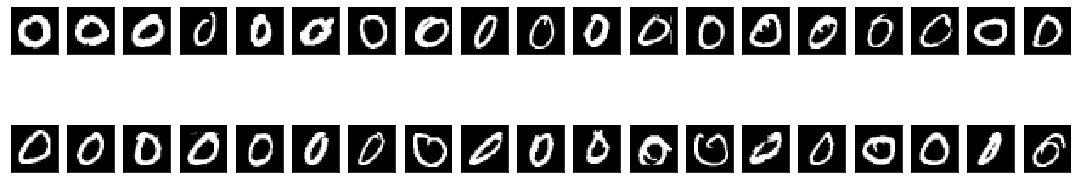

train label = 0 false_img


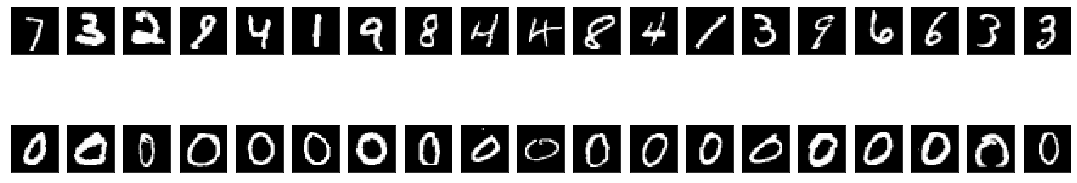

AUC: 0.929888852436762
confusion_matrix:
[[5022 3998]
 [  25  955]]


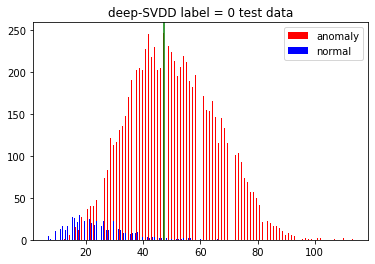

test label = 0 uncertain_img


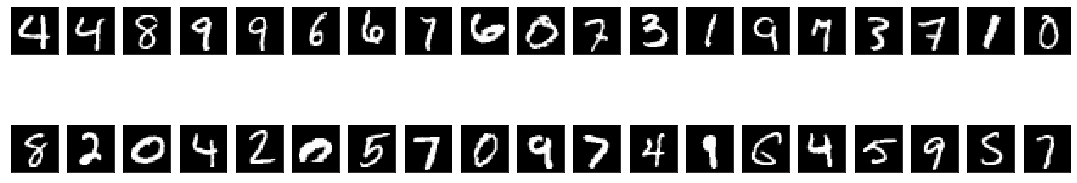

test label = 0 distance oder


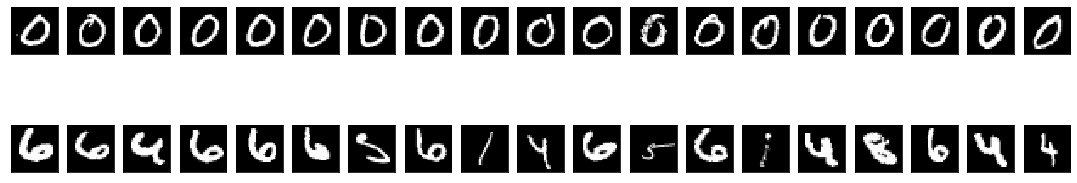

test label = 0 false_img


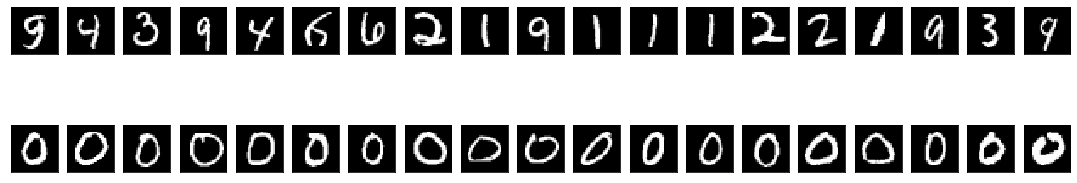

AUC: 0.9422529144005343
confusion_matrix:
[[ 171   93]
 [ 113 5286]]


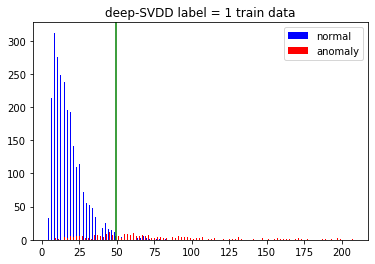

 train label = 1 uncertain_img


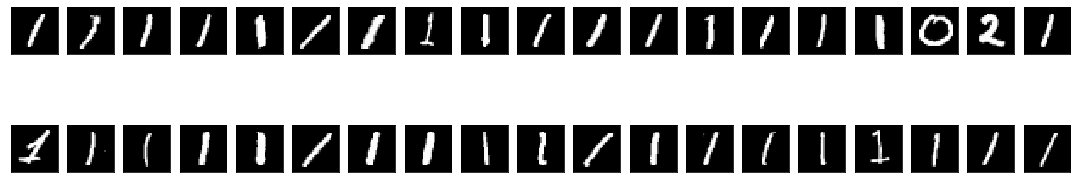

train label = 1 distance oder


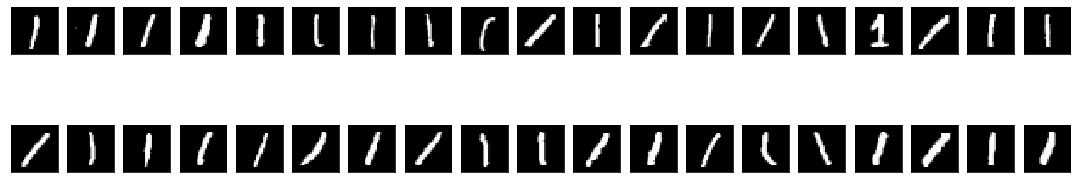

train label = 1 false_img


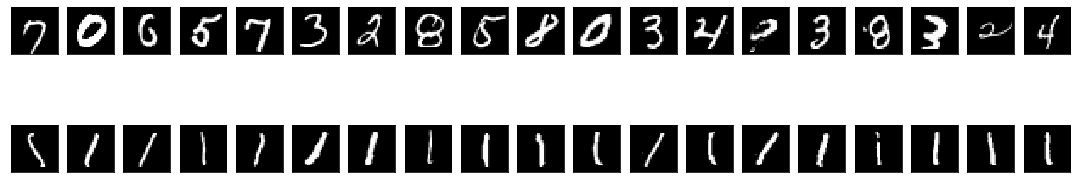

AUC: 0.9323464796221342
confusion_matrix:
[[5479 3386]
 [  31 1104]]


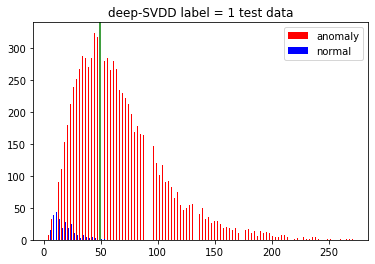

test label = 1 uncertain_img


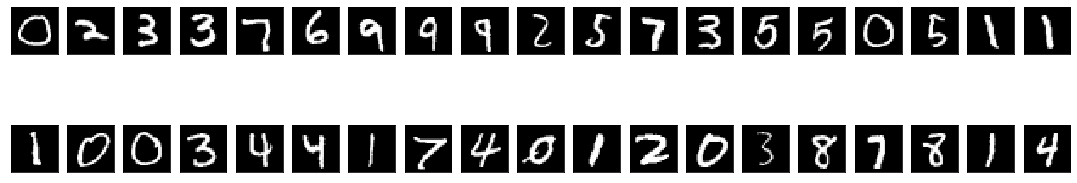

test label = 1 distance oder


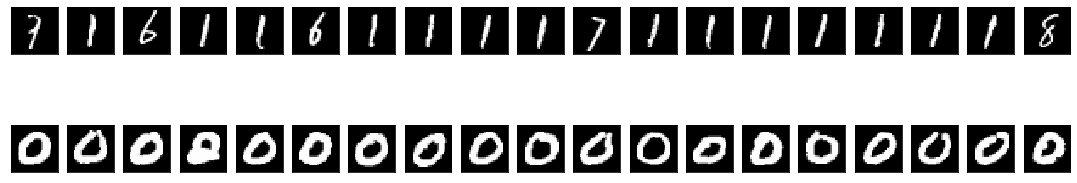

test label = 1 false_img


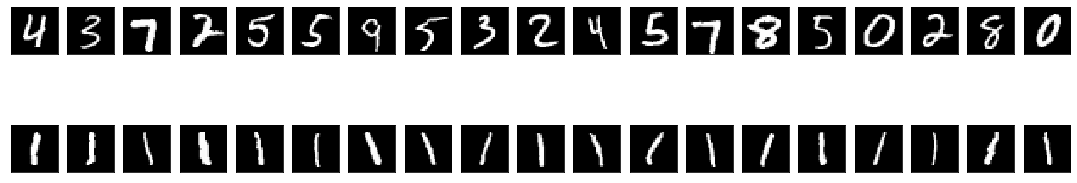

AUC: 0.7306916671583923
confusion_matrix:
[[  30  212]
 [ 221 4541]]


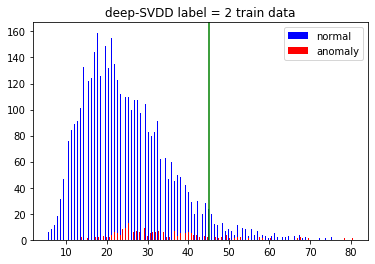

 train label = 2 uncertain_img


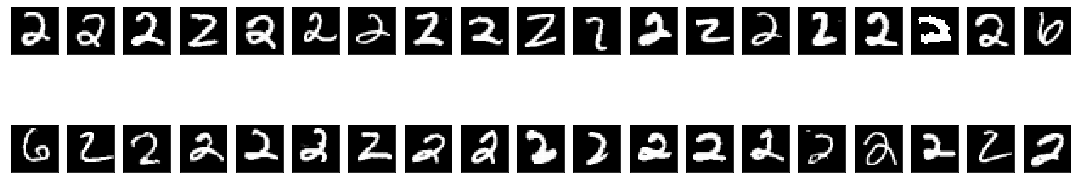

train label = 2 distance oder


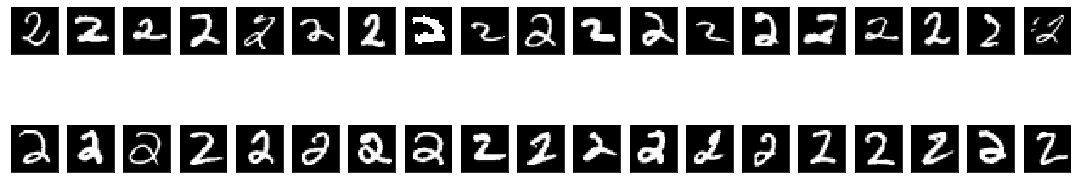

train label = 2 false_img


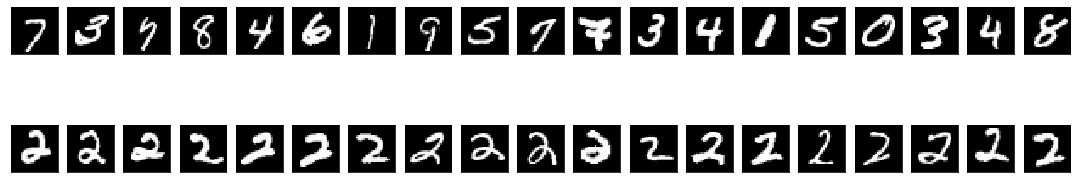

AUC: 0.7589253067755118
confusion_matrix:
[[1630 7338]
 [  44  988]]


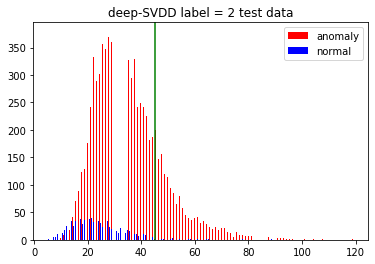

test label = 2 uncertain_img


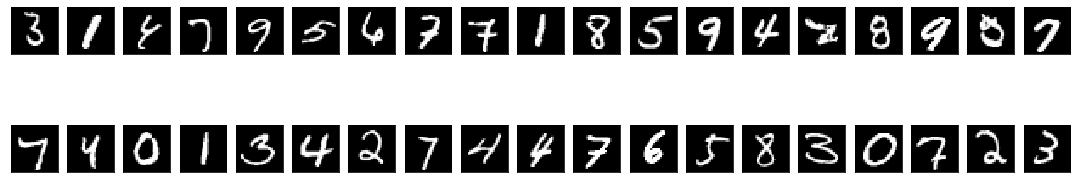

test label = 2 distance oder


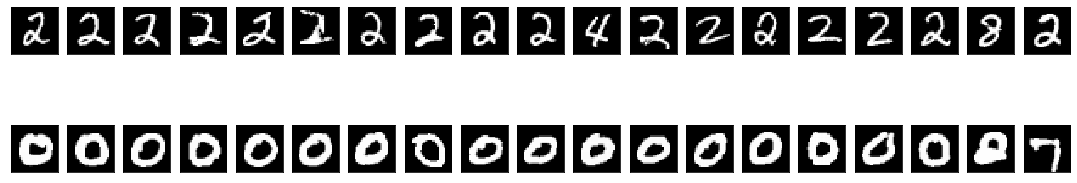

test label = 2 false_img


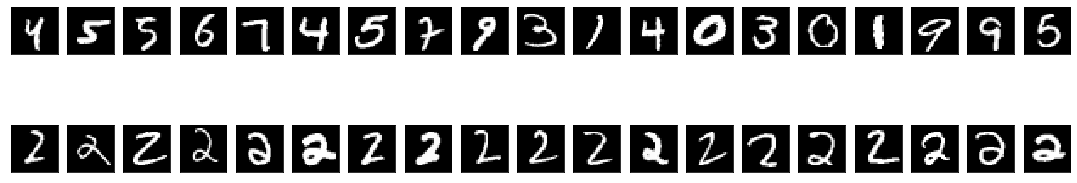

AUC: 0.7957505691720185
confusion_matrix:
[[  49  197]
 [ 209 4694]]


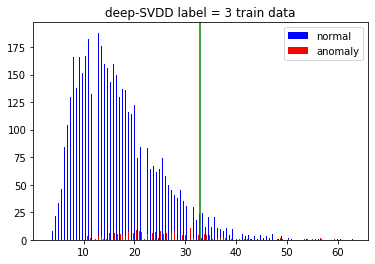

 train label = 3 uncertain_img


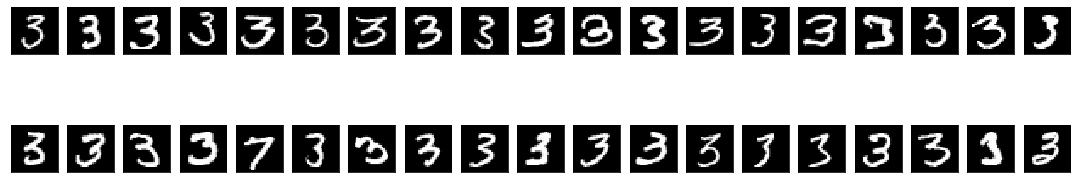

train label = 3 distance oder


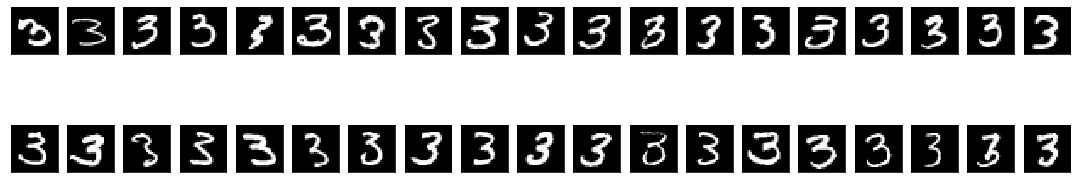

train label = 3 false_img


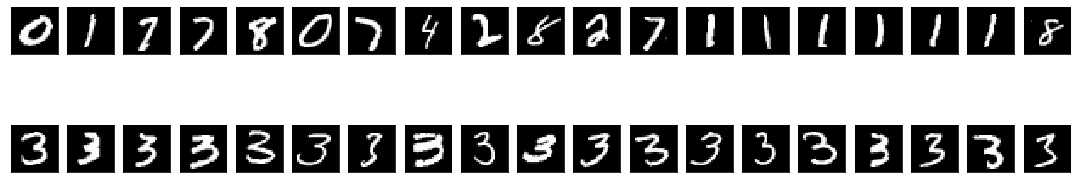

AUC: 0.8268225420984812
confusion_matrix:
[[2140 6850]
 [  34  976]]


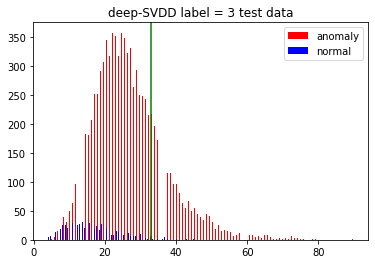

test label = 3 uncertain_img


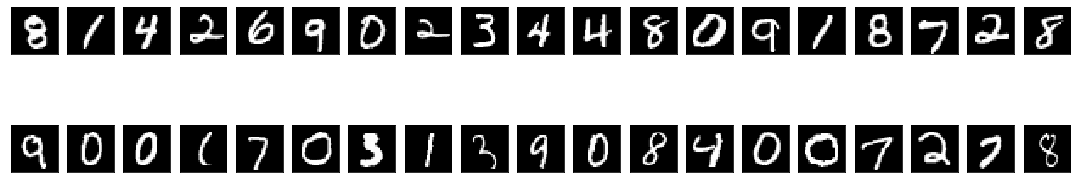

test label = 3 distance oder


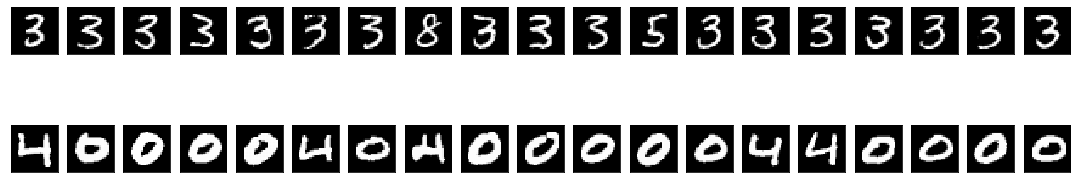

test label = 3 false_img


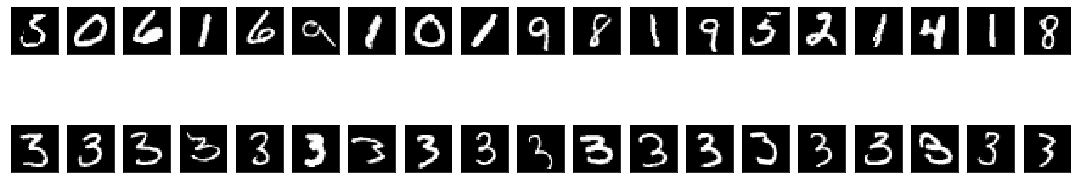

AUC: 0.8146366501371577
confusion_matrix:
[[  46  180]
 [ 199 4482]]


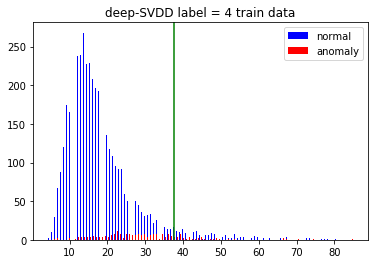

 train label = 4 uncertain_img


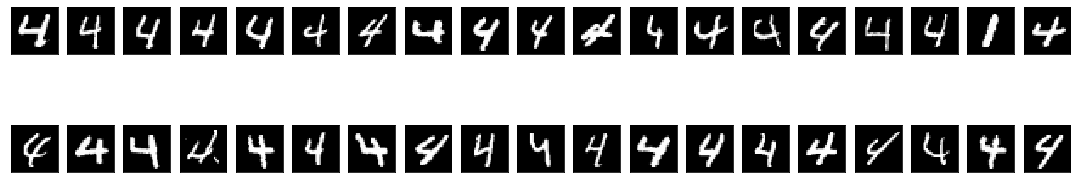

train label = 4 distance oder


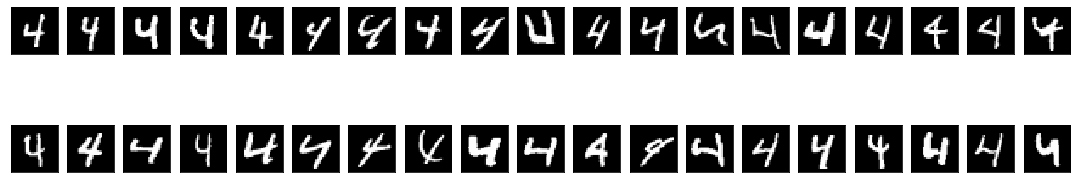

train label = 4 false_img


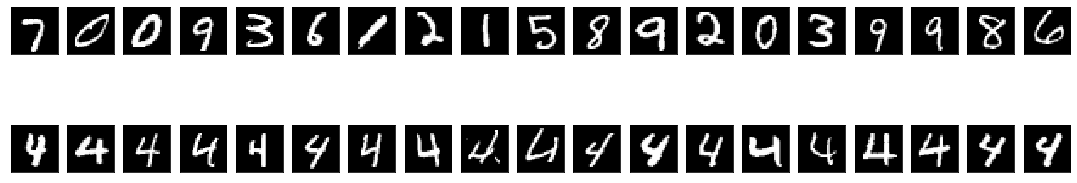

AUC: 0.8103059551862557
confusion_matrix:
[[2092 6926]
 [  44  938]]


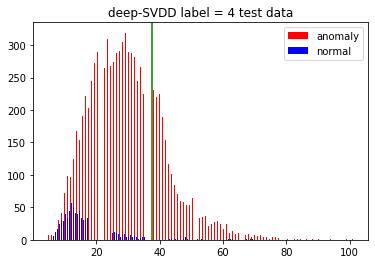

test label = 4 uncertain_img


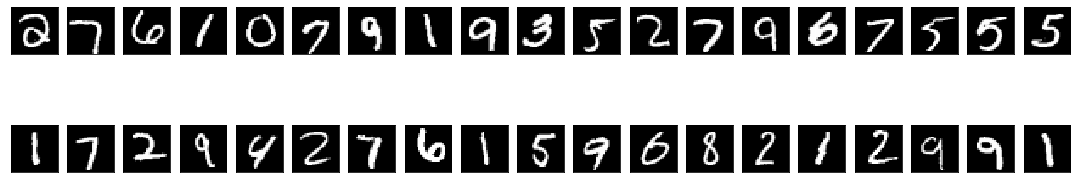

test label = 4 distance oder


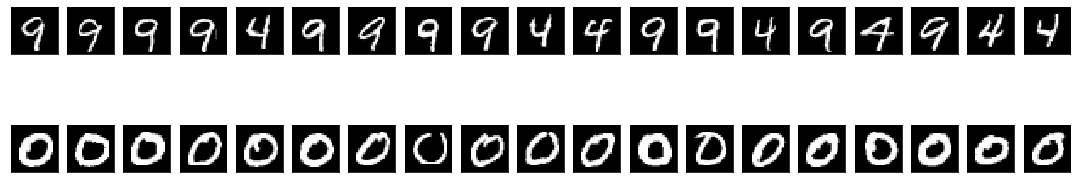

test label = 4 false_img


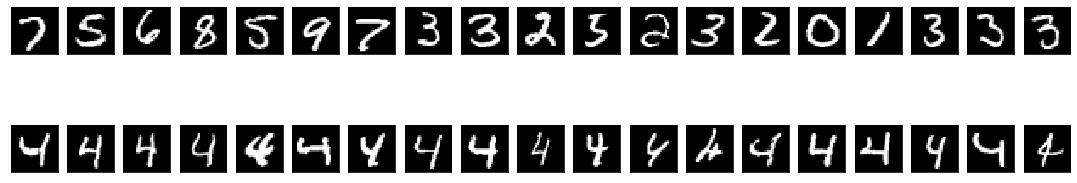

AUC: 0.586160023466594
confusion_matrix:
[[  14  203]
 [ 215 4121]]


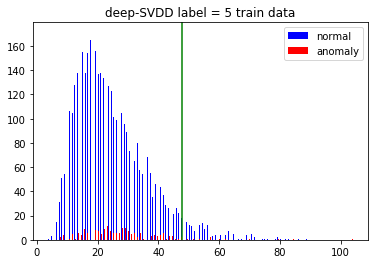

 train label = 5 uncertain_img


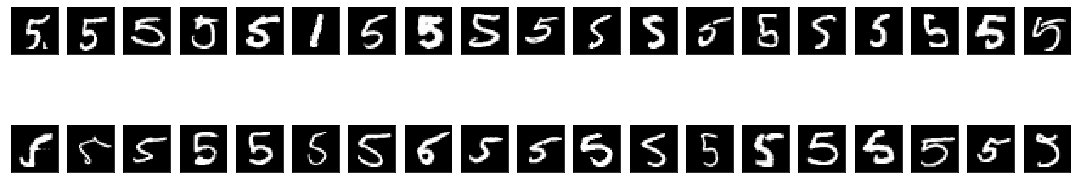

train label = 5 distance oder


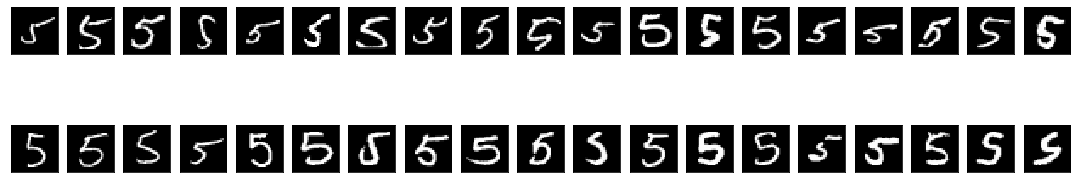

train label = 5 false_img


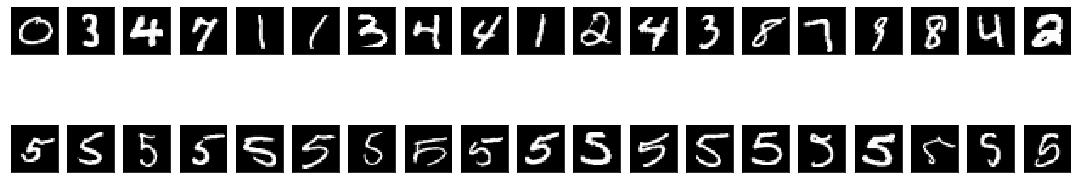

AUC: 0.6280918219039685
confusion_matrix:
[[ 932 8176]
 [  41  851]]


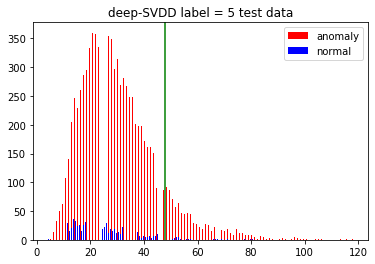

test label = 5 uncertain_img


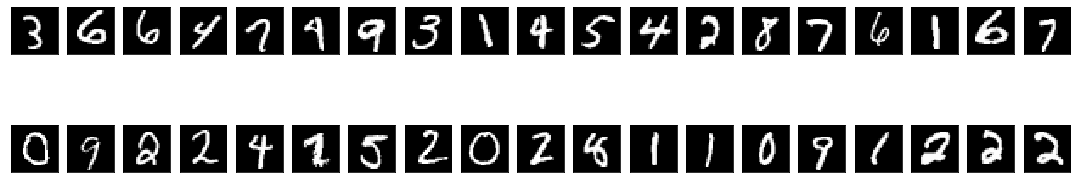

test label = 5 distance oder


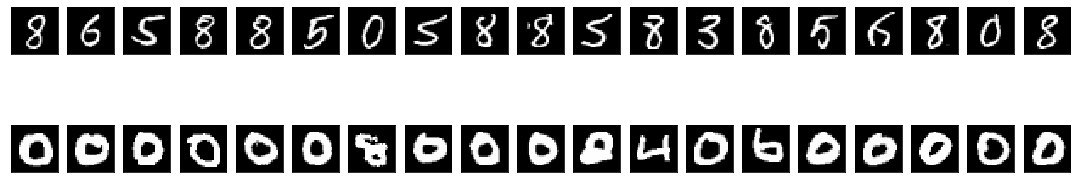

test label = 5 false_img


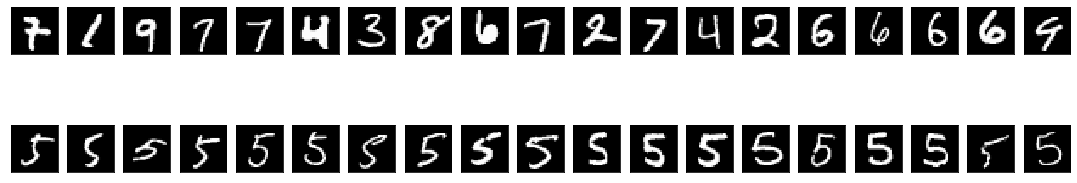

AUC: 0.8513936696765522
confusion_matrix:
[[  46  195]
 [ 203 4526]]


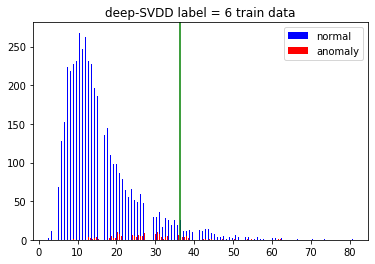

 train label = 6 uncertain_img


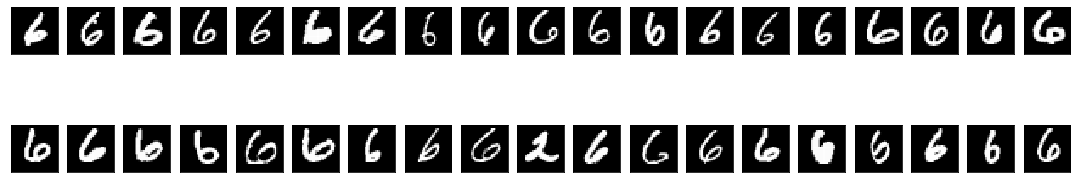

train label = 6 distance oder


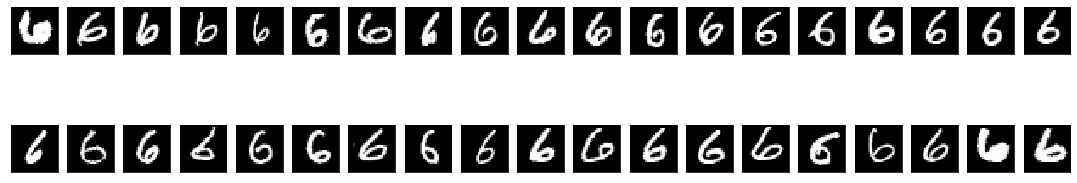

train label = 6 false_img


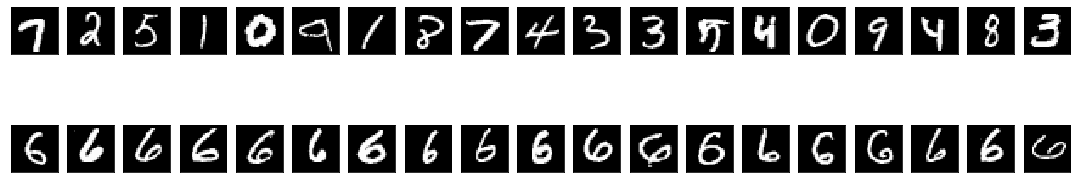

AUC: 0.8091093338948512
confusion_matrix:
[[1607 7435]
 [  50  908]]


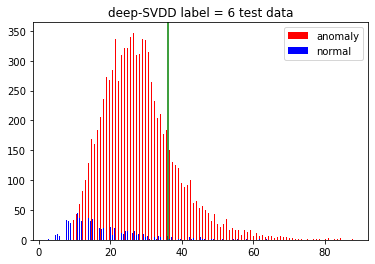

test label = 6 uncertain_img


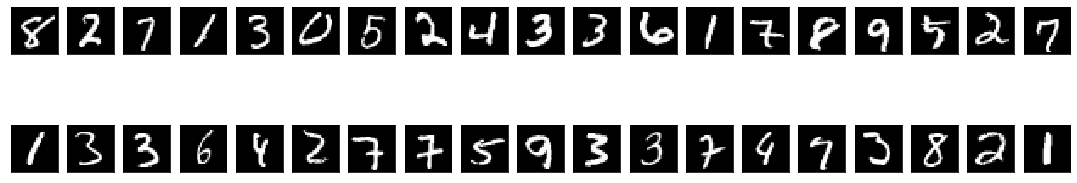

test label = 6 distance oder


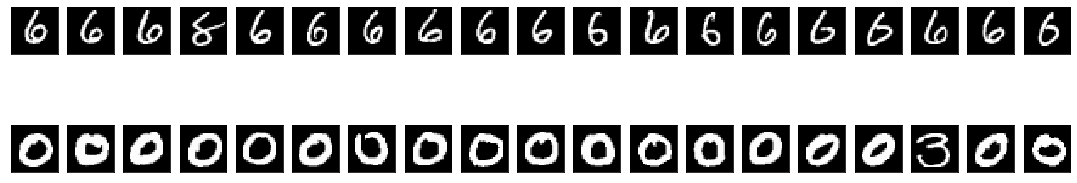

test label = 6 false_img


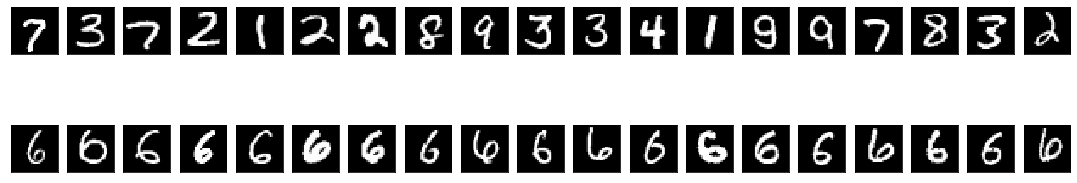

AUC: 0.816016008960005
confusion_matrix:
[[  58  197]
 [ 206 4801]]


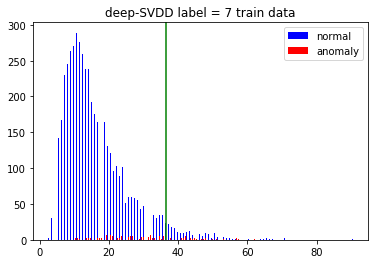

 train label = 7 uncertain_img


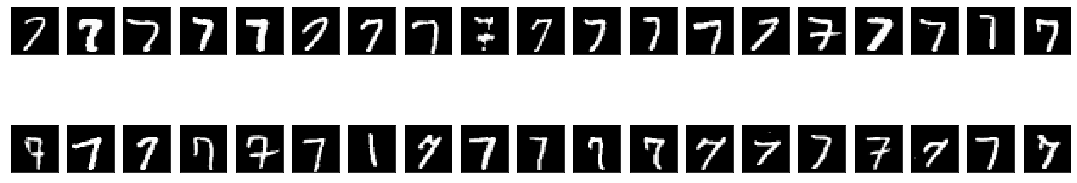

train label = 7 distance oder


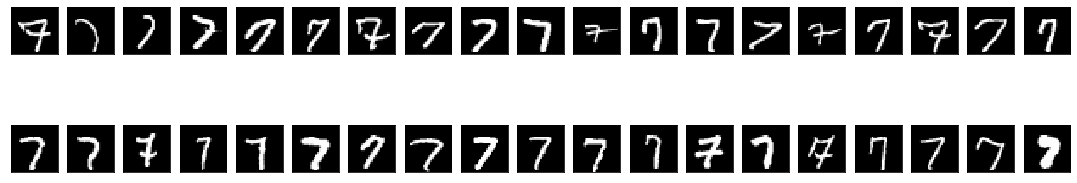

train label = 7 false_img


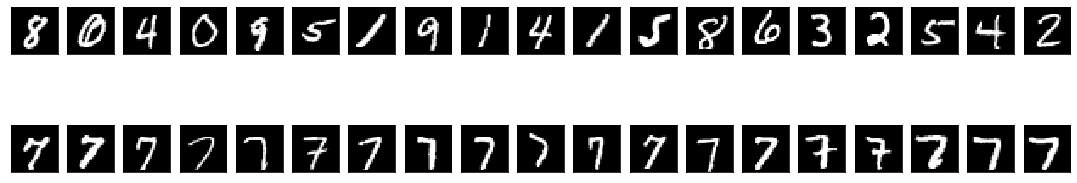

AUC: 0.7997993324671134
confusion_matrix:
[[1929 7043]
 [  43  985]]


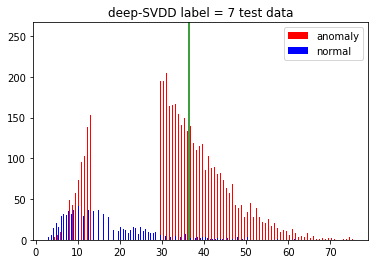

test label = 7 uncertain_img


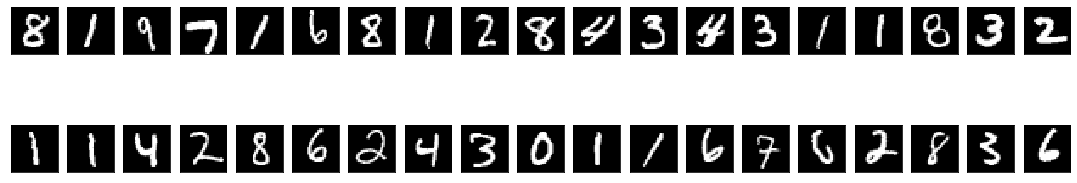

test label = 7 distance oder


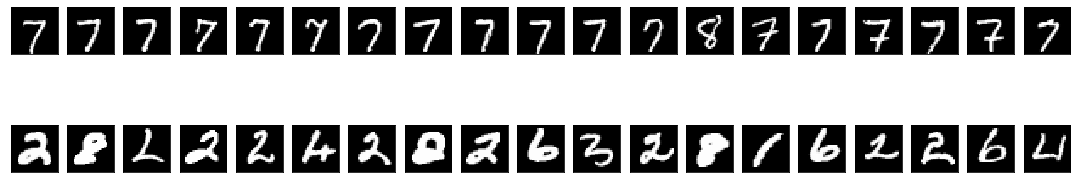

test label = 7 false_img


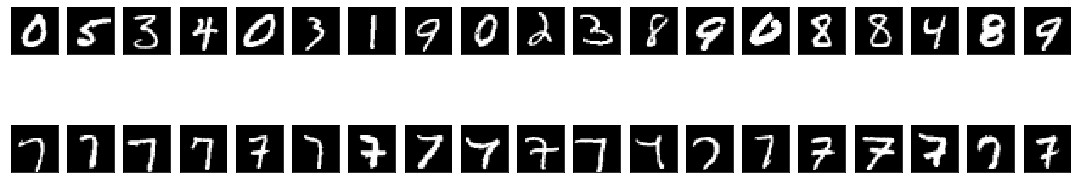

AUC: 0.8651385855370883
confusion_matrix:
[[  78  159]
 [ 169 4508]]


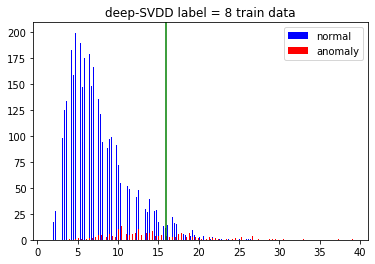

 train label = 8 uncertain_img


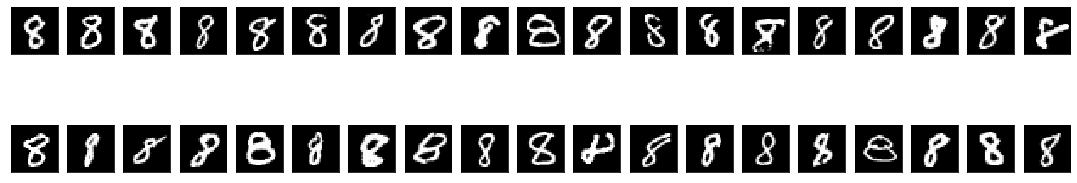

train label = 8 distance oder


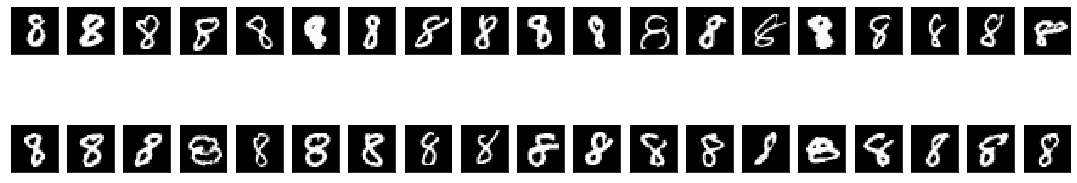

train label = 8 false_img


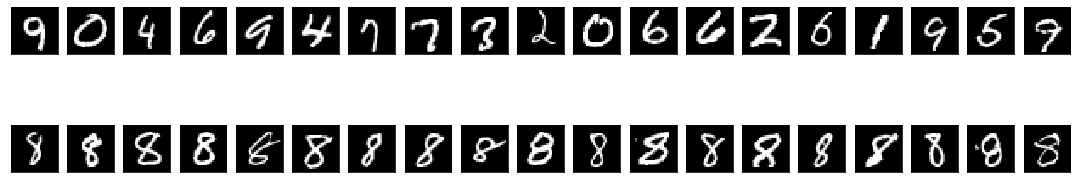

AUC: 0.8659512492088791
confusion_matrix:
[[2720 6306]
 [  30  944]]


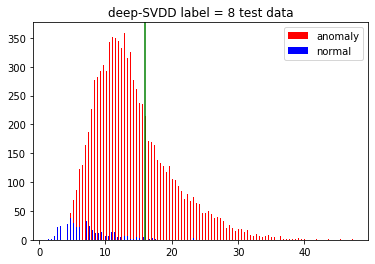

test label = 8 uncertain_img


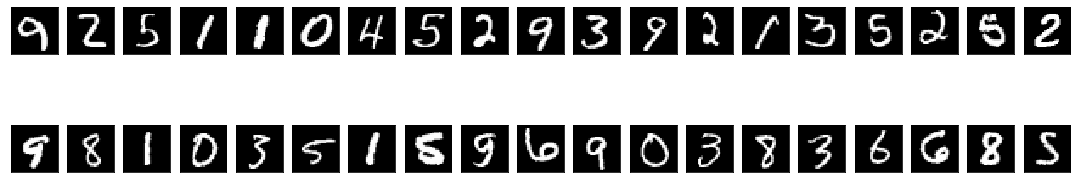

test label = 8 distance oder


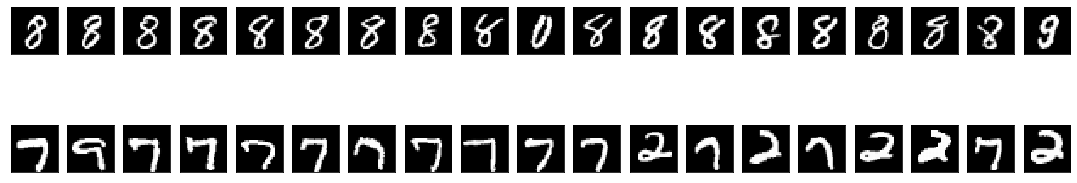

test label = 8 false_img


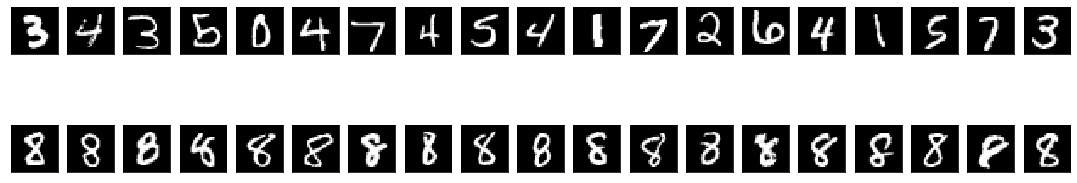

AUC: 0.8546122680158661
confusion_matrix:
[[  81  151]
 [ 170 4594]]


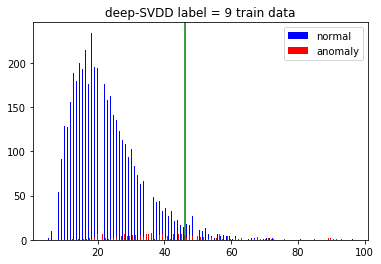

 train label = 9 uncertain_img


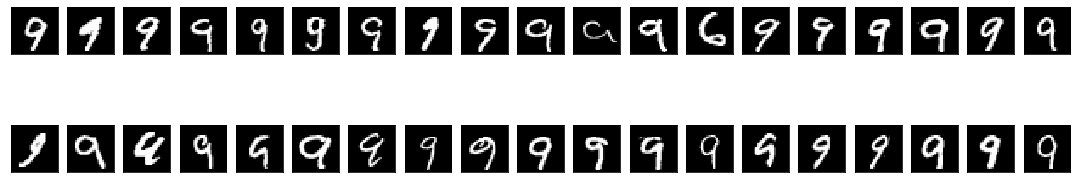

train label = 9 distance oder


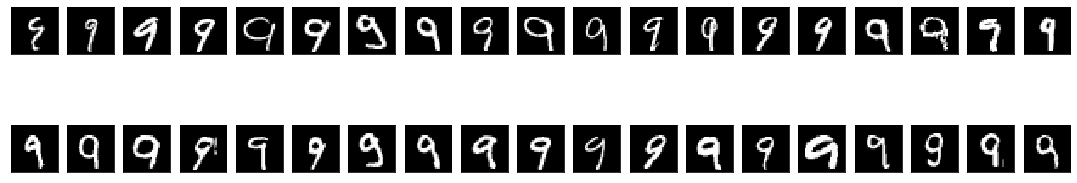

train label = 9 false_img


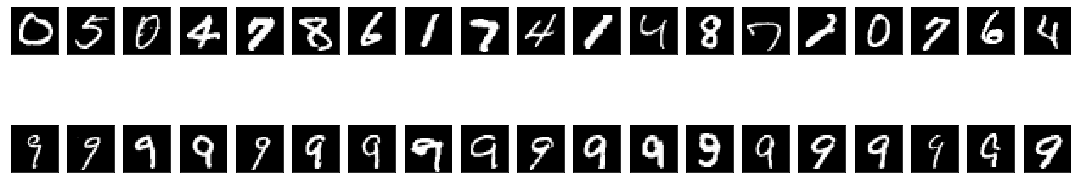

AUC: 0.8534689297821112
confusion_matrix:
[[2980 6011]
 [  28  981]]


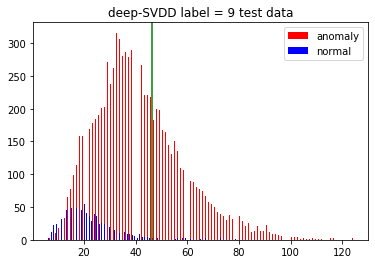

test label = 9 uncertain_img


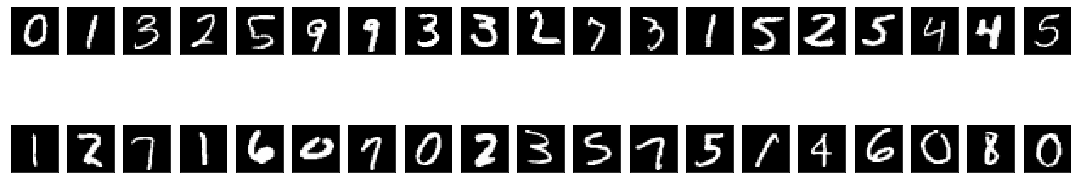

test label = 9 distance oder


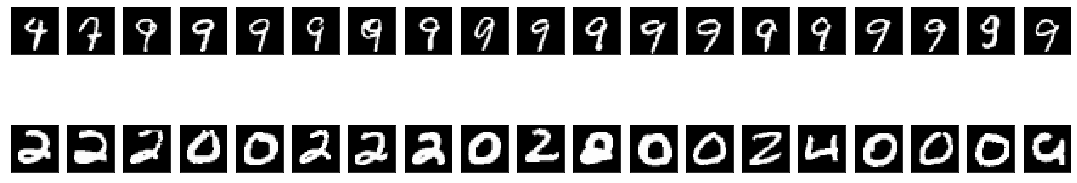

test label = 9 false_img


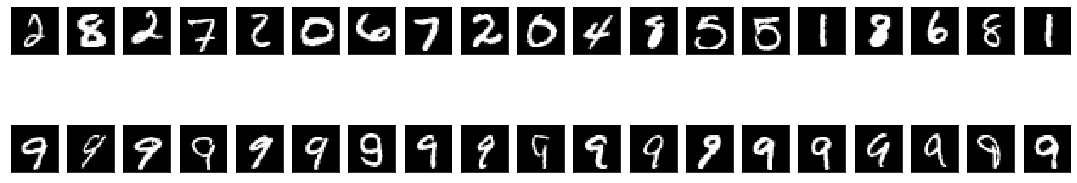

In [12]:
objective = 'deep-SVDD'
nu = 0.05
outlier_nu = 0.05
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [83]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [84]:
objective = 'deep-SVDD'
nu = 0.1
outlier_nu = 0.1
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)

auc =  0.9053621770215846
auc =  0.986910659401547
auc =  0.7518787731054084
auc =  0.8433038910120155
auc =  0.8745680171677466
auc =  0.7790143096001937
auc =  0.9083329061918886
auc =  0.8951632489144784
auc =  0.8405994933186401
auc =  0.9266589571622057


In [85]:
result

array([[ 0.        ,  0.        ,  0.90536218, 42.21283531],
       [ 1.        ,  0.        ,  0.98691066, 46.98259783],
       [ 2.        ,  0.        ,  0.75187877, 42.12805033],
       [ 3.        ,  0.        ,  0.84330389, 42.4440546 ],
       [ 4.        ,  0.        ,  0.87456802, 40.80307317],
       [ 5.        ,  0.        ,  0.77901431, 38.67813325],
       [ 6.        ,  0.        ,  0.90833291, 41.92463565],
       [ 7.        ,  0.        ,  0.89516325, 43.99518275],
       [ 8.        ,  0.        ,  0.84059949, 43.22574925],
       [ 9.        ,  0.        ,  0.92665896, 41.44371796]])

AUC: 0.9186868978199159
confusion_matrix:
[[ 285  199]
 [ 237 4491]]


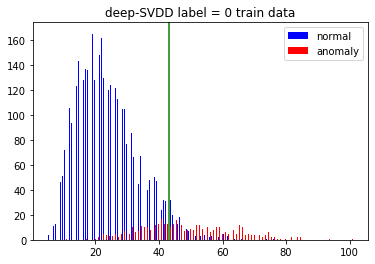

 train label = 0 uncertain_img


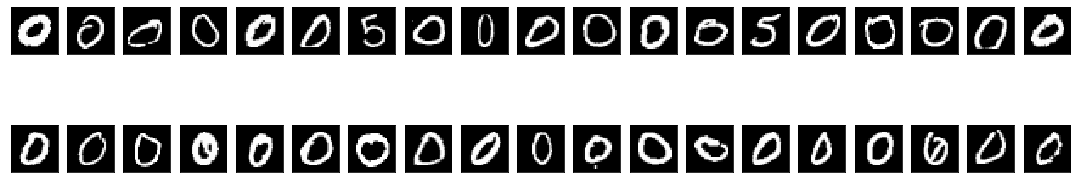

train label = 0 distance oder


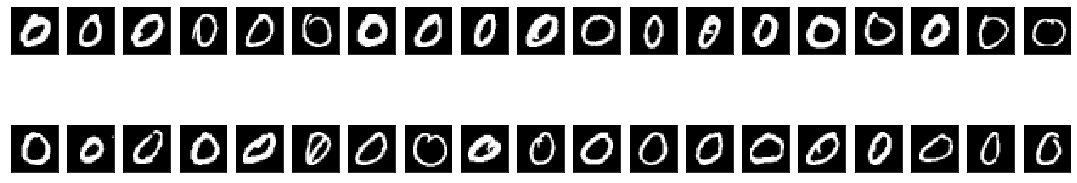

train label = 0 false_img


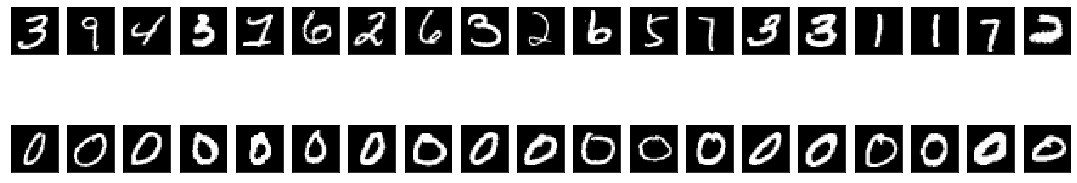

AUC: 0.9100352957147383
confusion_matrix:
[[5354 3666]
 [  55  925]]


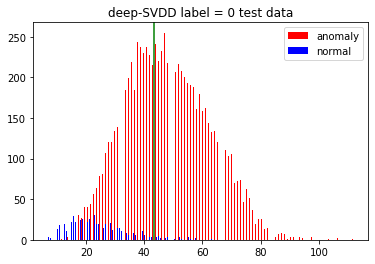

test label = 0 uncertain_img


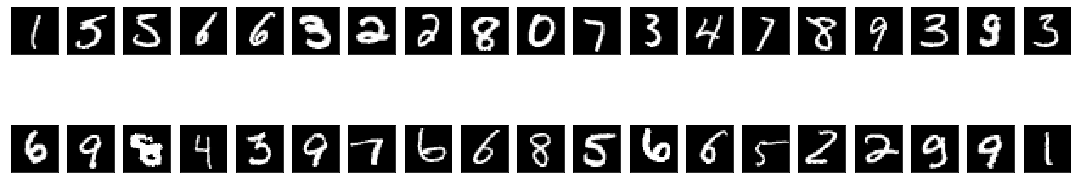

test label = 0 distance oder


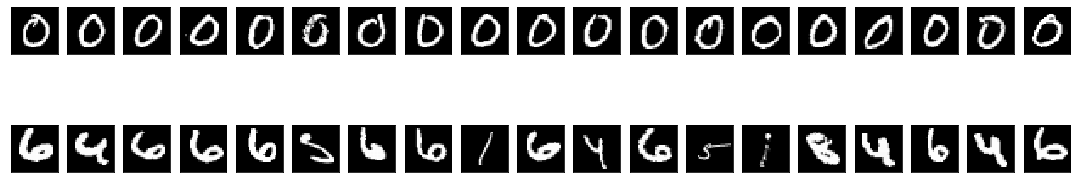

test label = 0 false_img


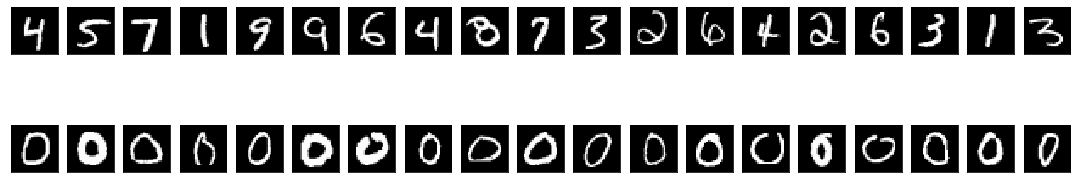

AUC: 0.9124063741436231
confusion_matrix:
[[ 363  191]
 [ 231 5147]]


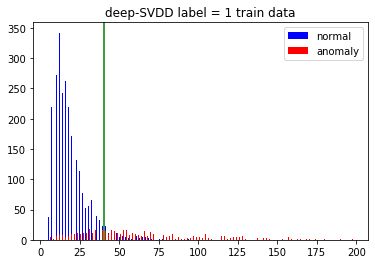

 train label = 1 uncertain_img


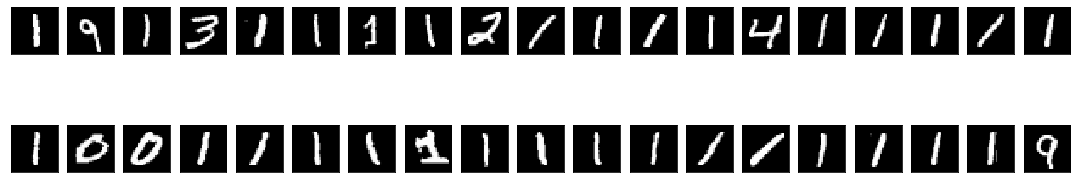

train label = 1 distance oder


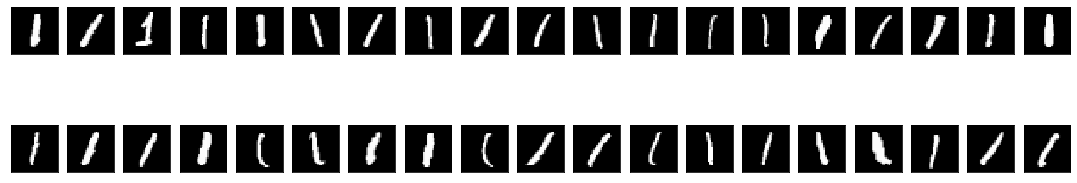

train label = 1 false_img


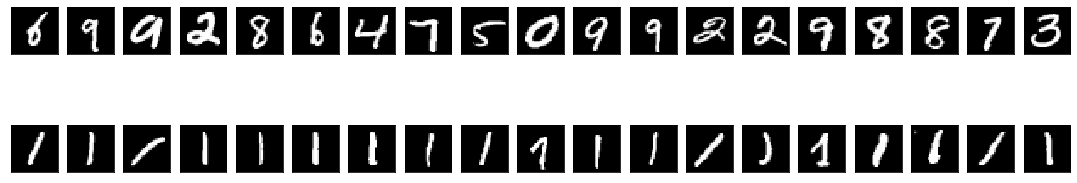

AUC: 0.9228374715196871
confusion_matrix:
[[6230 2635]
 [  63 1072]]


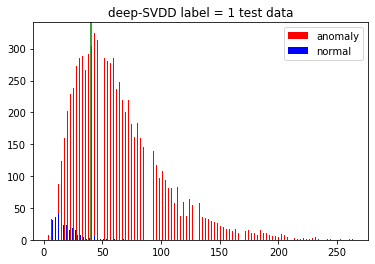

test label = 1 uncertain_img


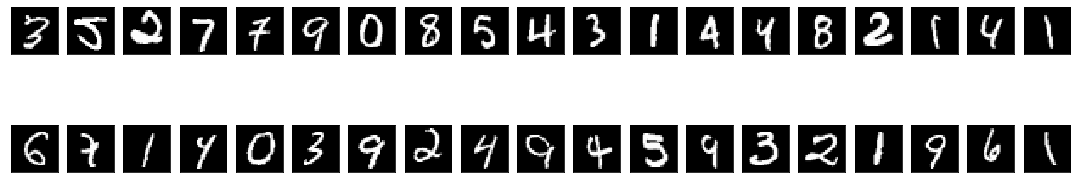

test label = 1 distance oder


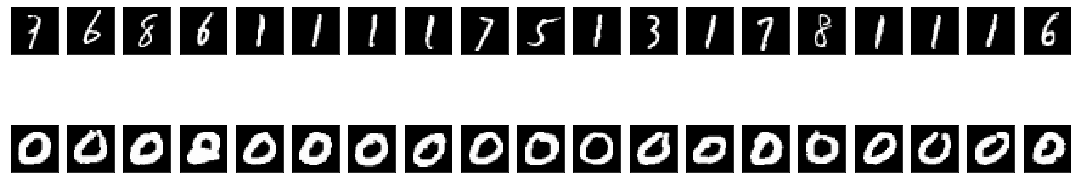

test label = 1 false_img


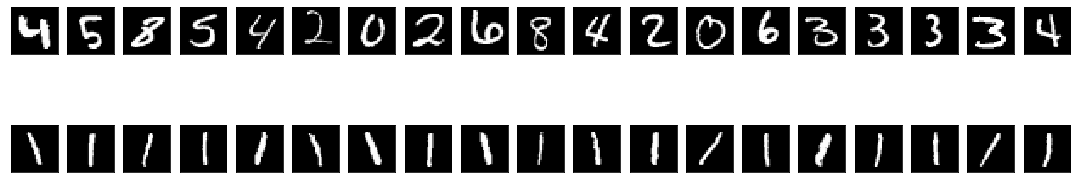

AUC: 0.7204834079223108
confusion_matrix:
[[ 117  366]
 [ 408 4351]]


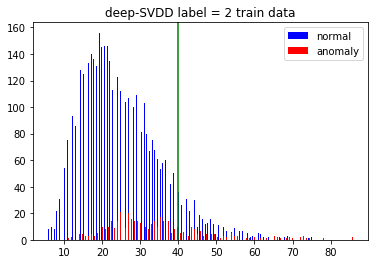

 train label = 2 uncertain_img


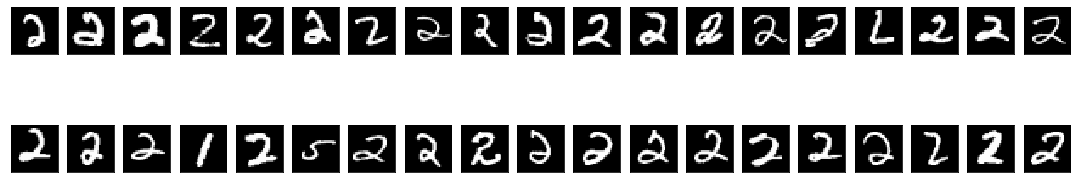

train label = 2 distance oder


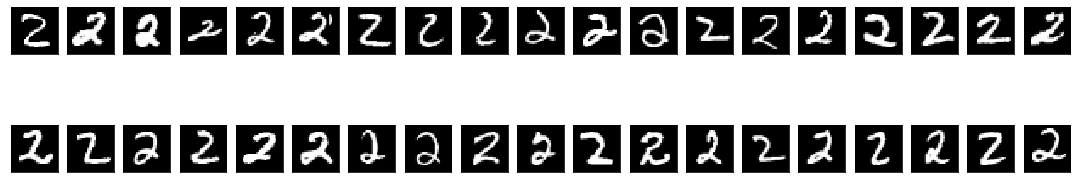

train label = 2 false_img


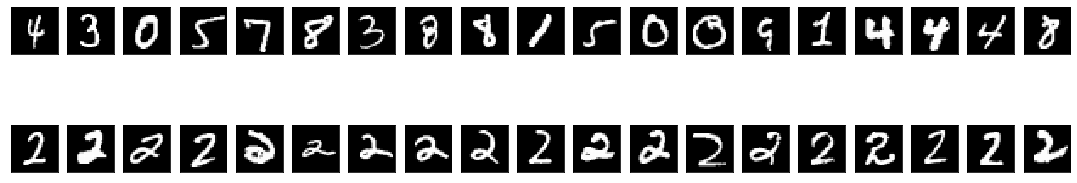

AUC: 0.7433293181959629
confusion_matrix:
[[2410 6558]
 [  84  948]]


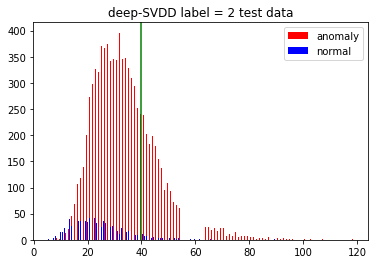

test label = 2 uncertain_img


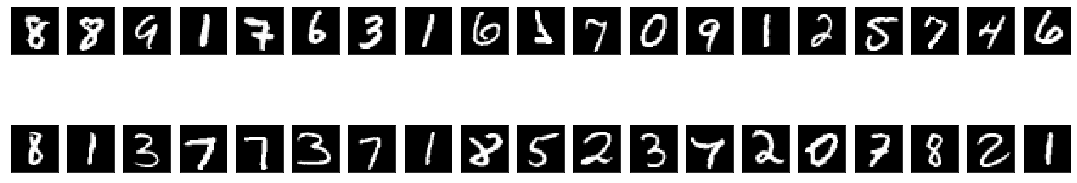

test label = 2 distance oder


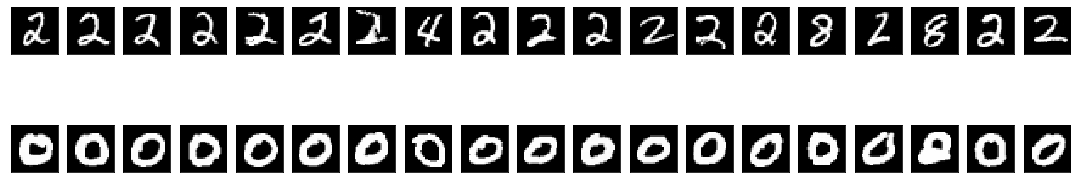

test label = 2 false_img


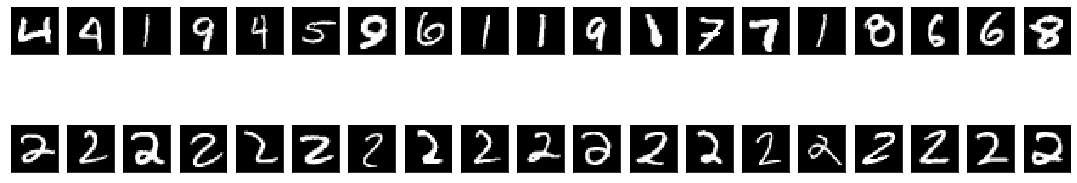

AUC: 0.7976886618998978
confusion_matrix:
[[ 170  330]
 [ 370 4525]]


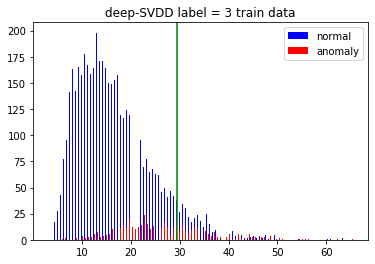

 train label = 3 uncertain_img


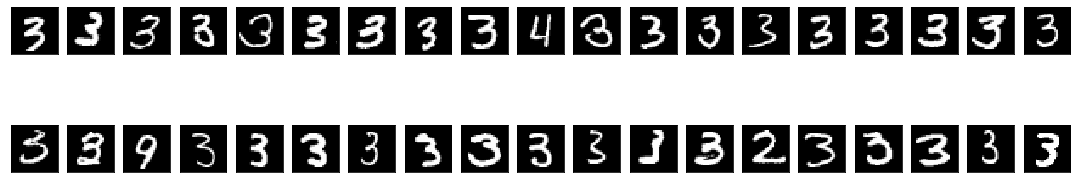

train label = 3 distance oder


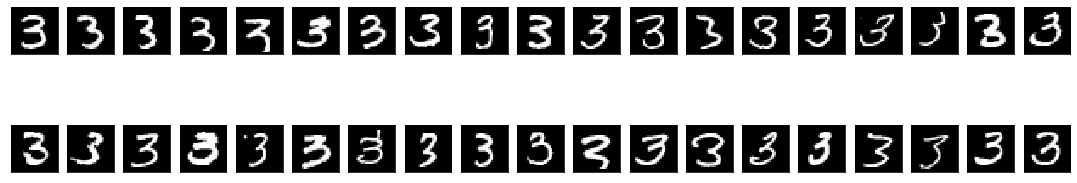

train label = 3 false_img


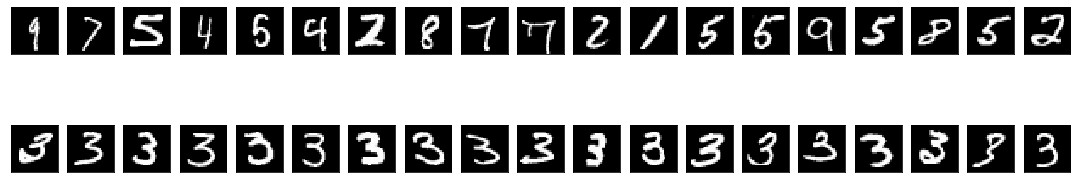

AUC: 0.8116625733763588
confusion_matrix:
[[2880 6110]
 [  53  957]]


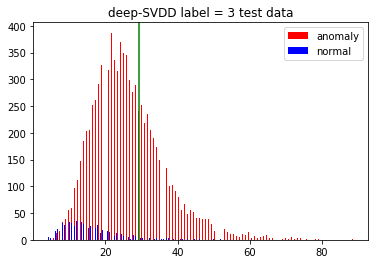

test label = 3 uncertain_img


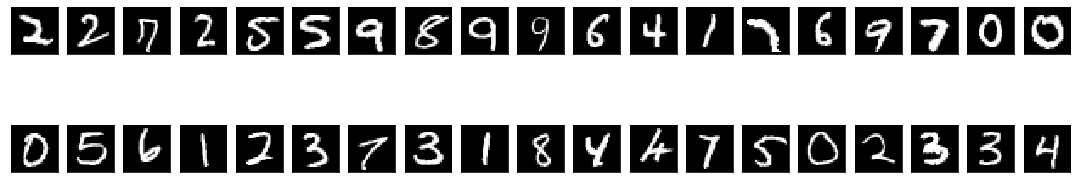

test label = 3 distance oder


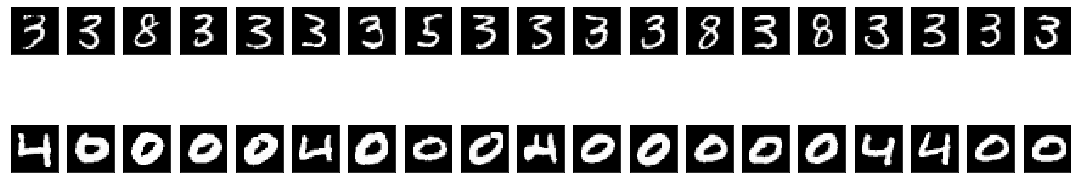

test label = 3 false_img


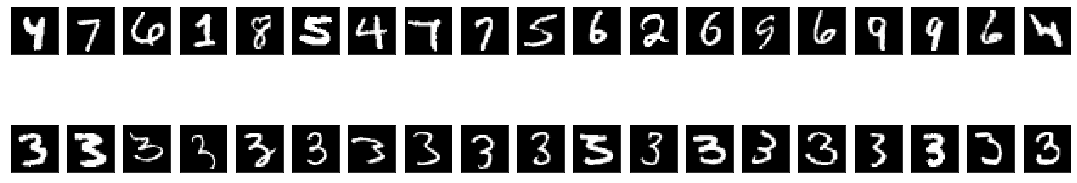

AUC: 0.8051473447382176
confusion_matrix:
[[ 163  311]
 [ 352 4314]]


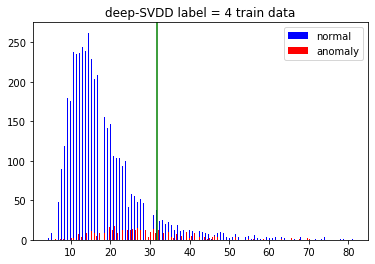

 train label = 4 uncertain_img


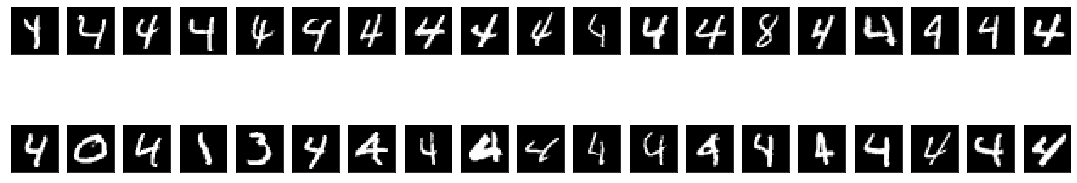

train label = 4 distance oder


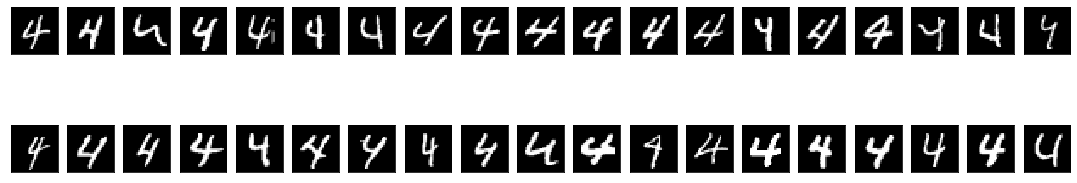

train label = 4 false_img


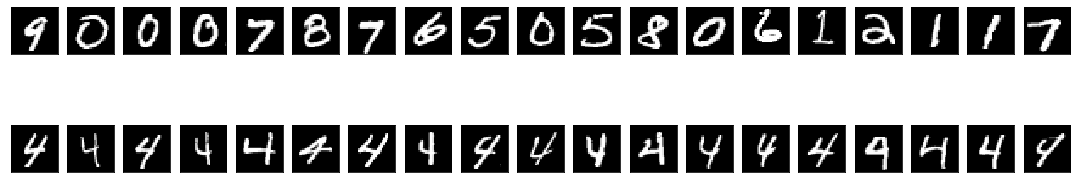

AUC: 0.7995902289108138
confusion_matrix:
[[3352 5666]
 [  78  904]]


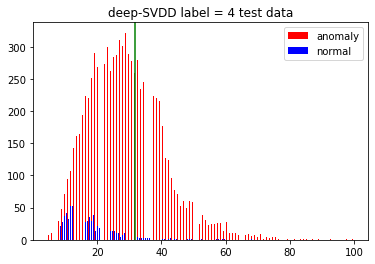

test label = 4 uncertain_img


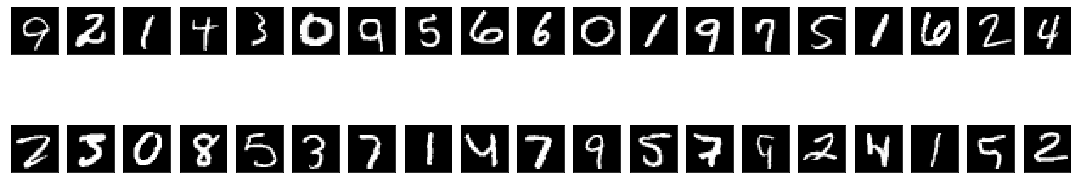

test label = 4 distance oder


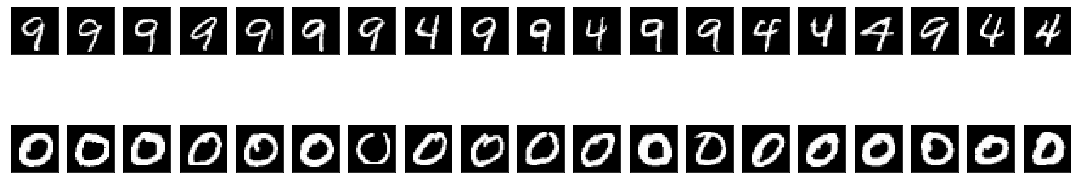

test label = 4 false_img


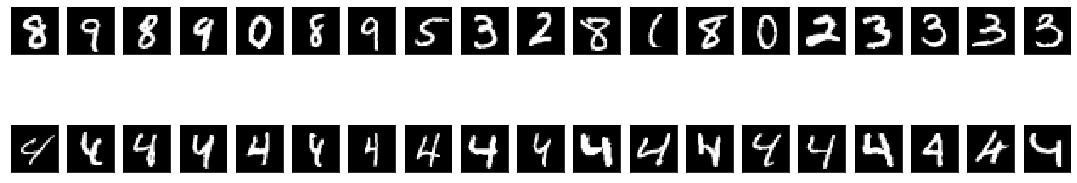

AUC: 0.6002564585840329
confusion_matrix:
[[  71  358]
 [ 407 3934]]


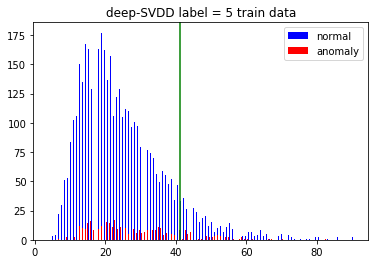

 train label = 5 uncertain_img


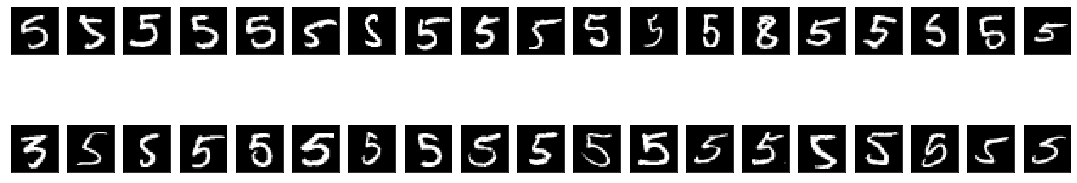

train label = 5 distance oder


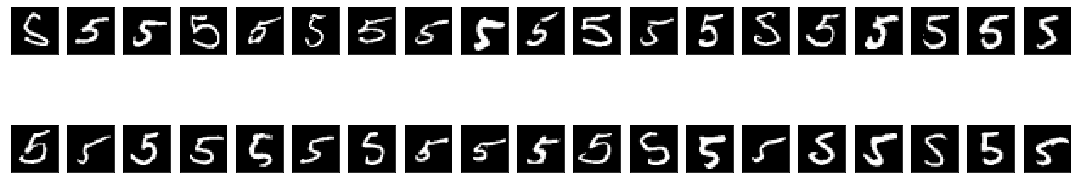

train label = 5 false_img


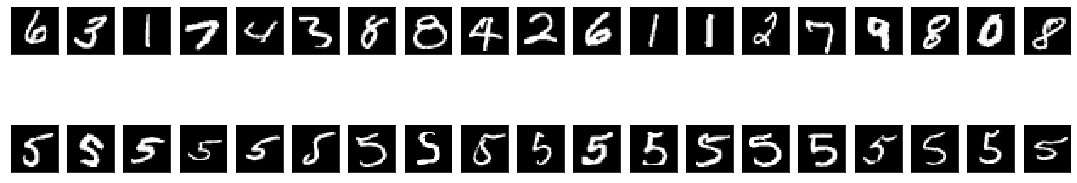

AUC: 0.6161778636432564
confusion_matrix:
[[1555 7553]
 [  97  795]]


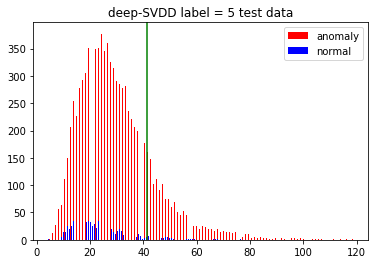

test label = 5 uncertain_img


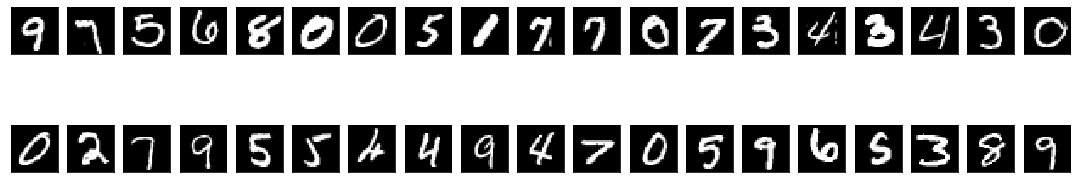

test label = 5 distance oder


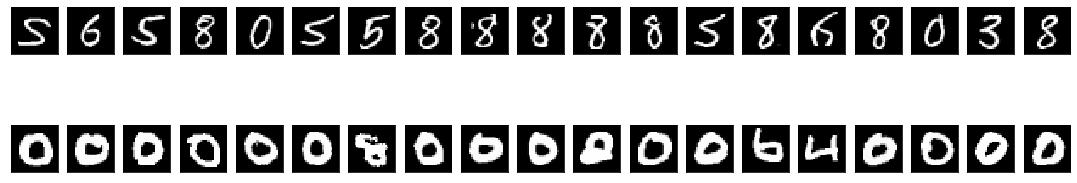

test label = 5 false_img


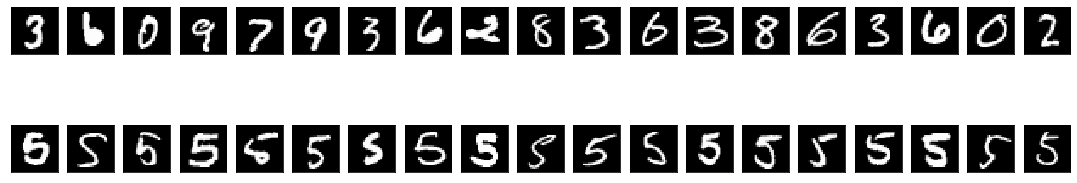

AUC: 0.8303684113216344
confusion_matrix:
[[ 157  316]
 [ 365 4369]]


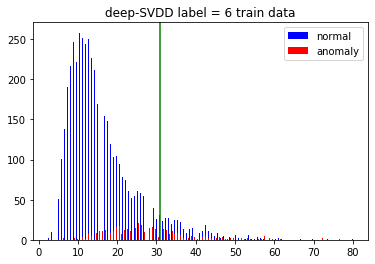

 train label = 6 uncertain_img


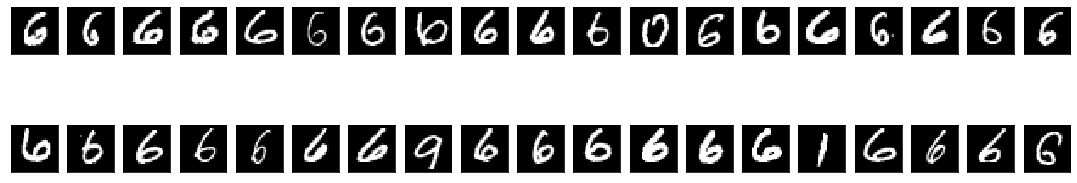

train label = 6 distance oder


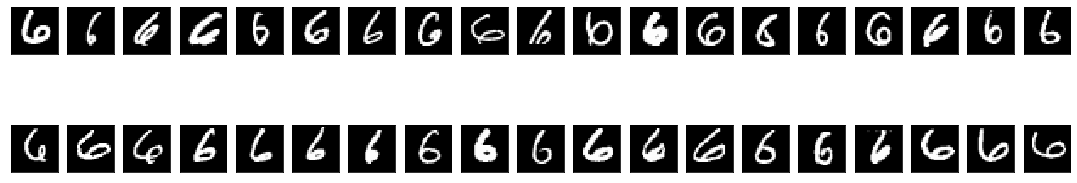

train label = 6 false_img


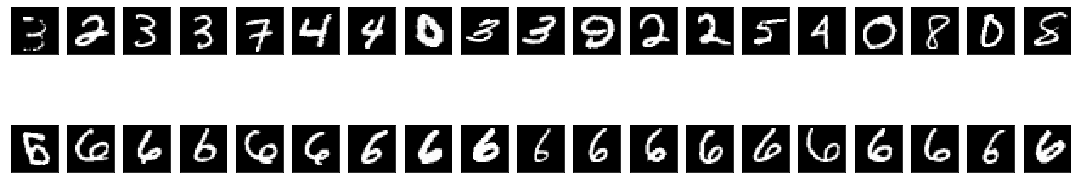

AUC: 0.793539624180177
confusion_matrix:
[[2692 6350]
 [  86  872]]


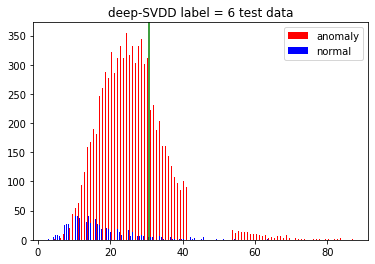

test label = 6 uncertain_img


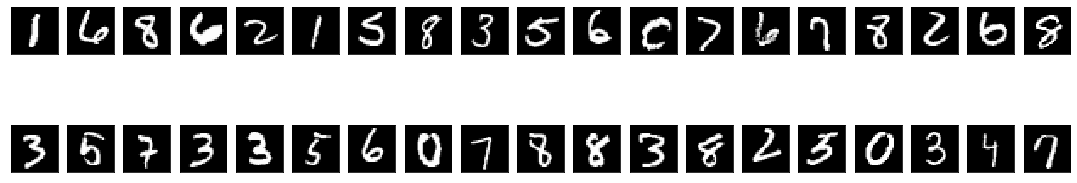

test label = 6 distance oder


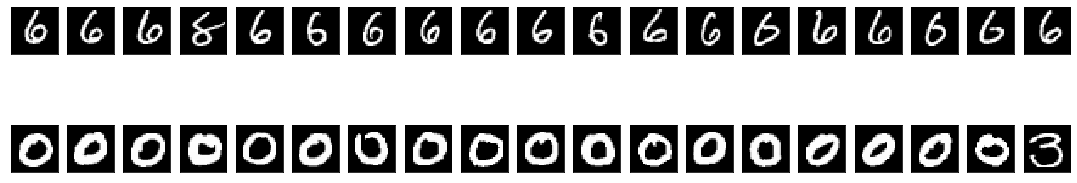

test label = 6 false_img


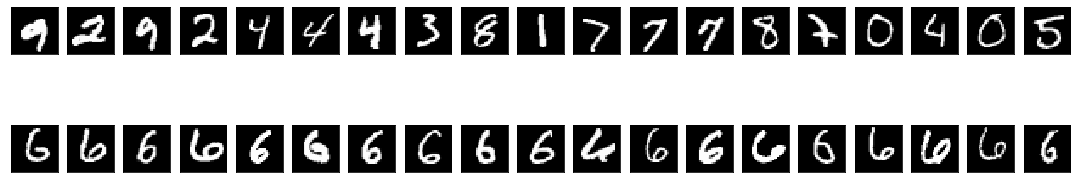

AUC: 0.8029416046574271
confusion_matrix:
[[ 175  339]
 [ 376 4622]]


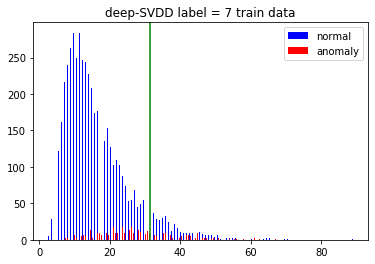

 train label = 7 uncertain_img


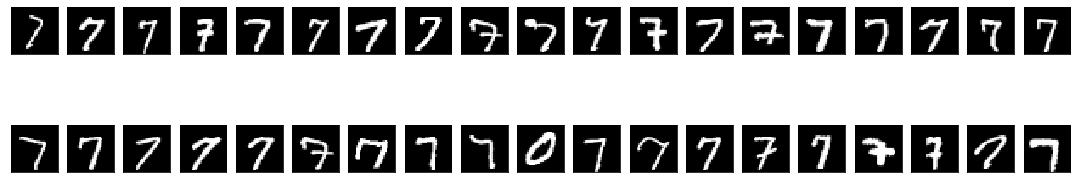

train label = 7 distance oder


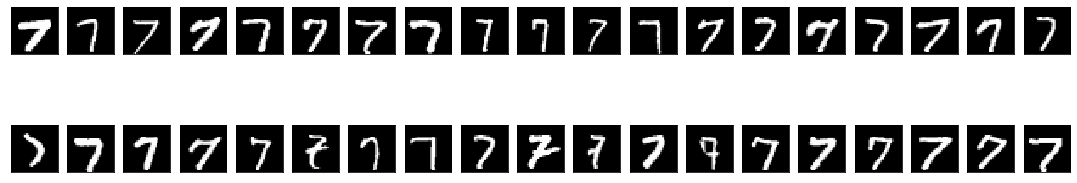

train label = 7 false_img


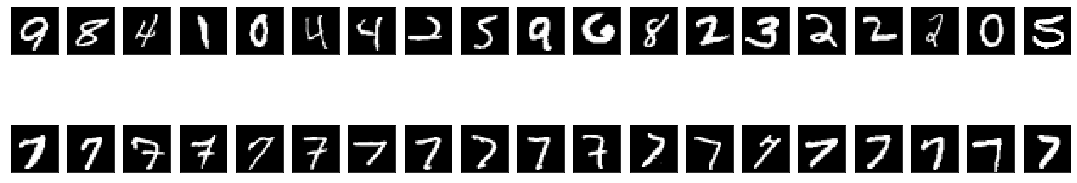

AUC: 0.7906259595351556
confusion_matrix:
[[2841 6131]
 [  74  954]]


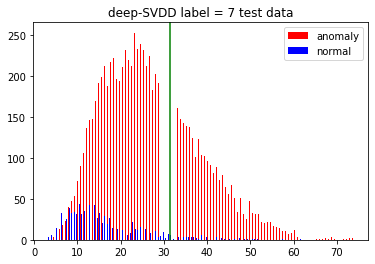

test label = 7 uncertain_img


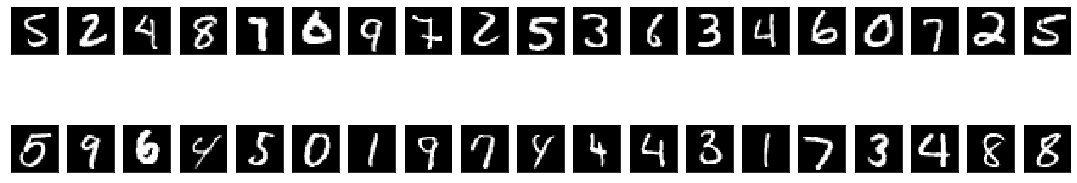

test label = 7 distance oder


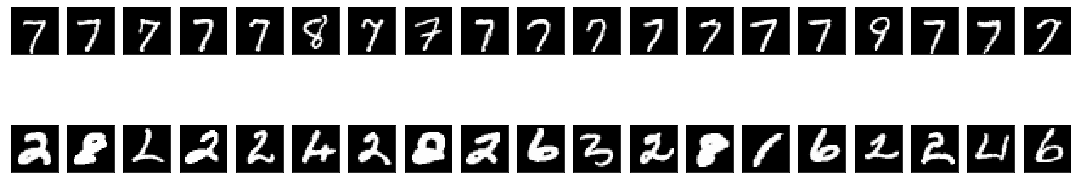

test label = 7 false_img


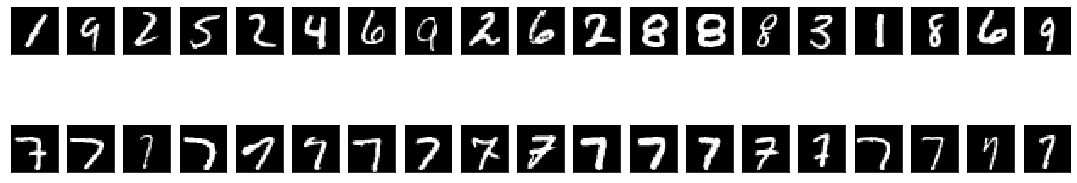

AUC: 0.8335514596284581
confusion_matrix:
[[ 187  290]
 [ 329 4342]]


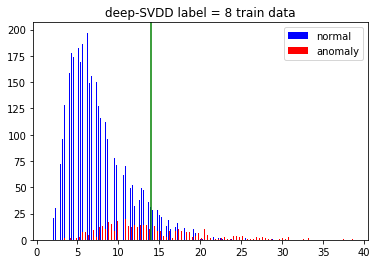

 train label = 8 uncertain_img


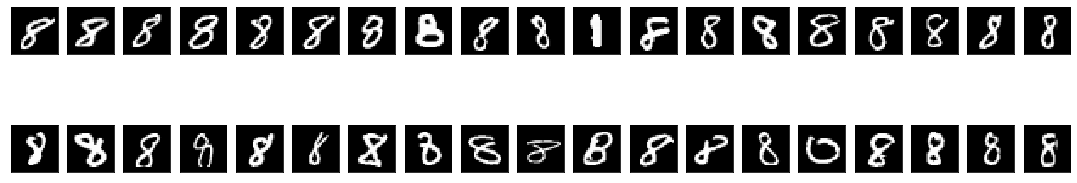

train label = 8 distance oder


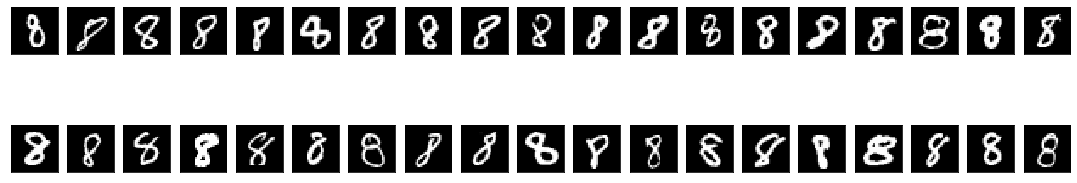

train label = 8 false_img


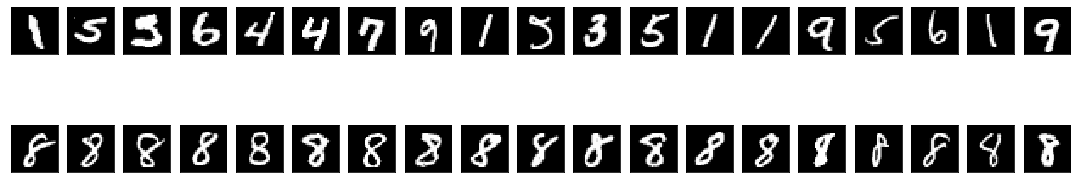

AUC: 0.8583687167029677
confusion_matrix:
[[3615 5411]
 [  57  917]]


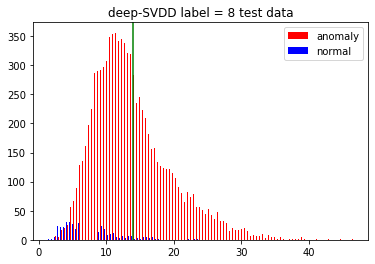

test label = 8 uncertain_img


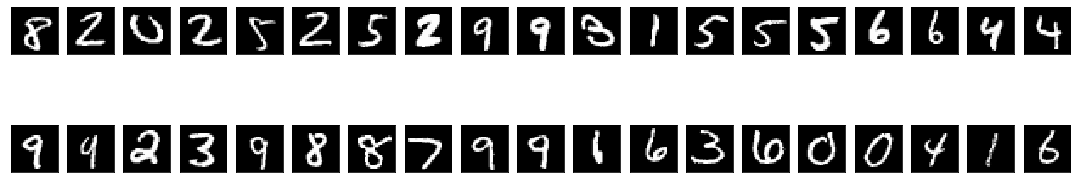

test label = 8 distance oder


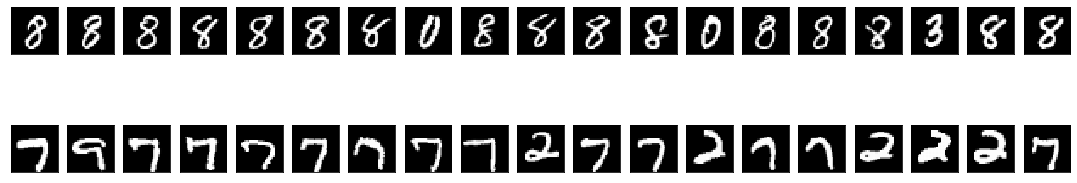

test label = 8 false_img


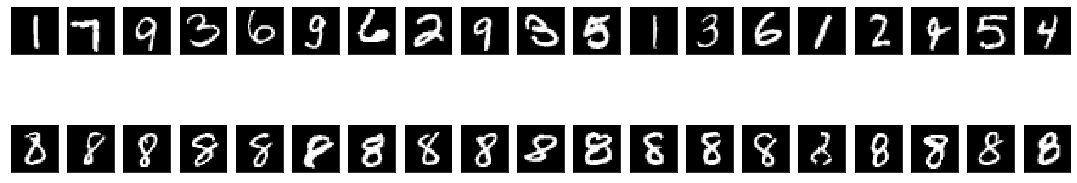

AUC: 0.8411694127587664
confusion_matrix:
[[ 234  266]
 [ 290 4444]]


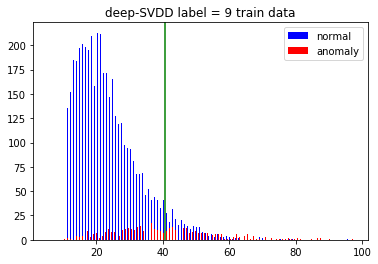

 train label = 9 uncertain_img


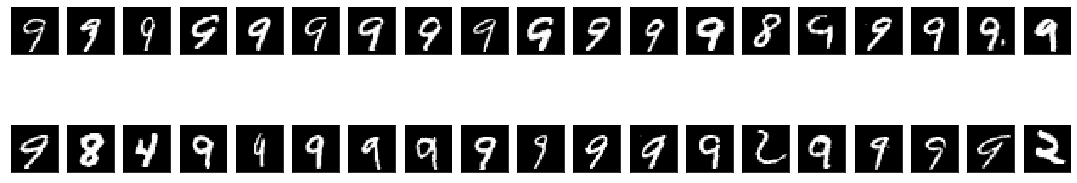

train label = 9 distance oder


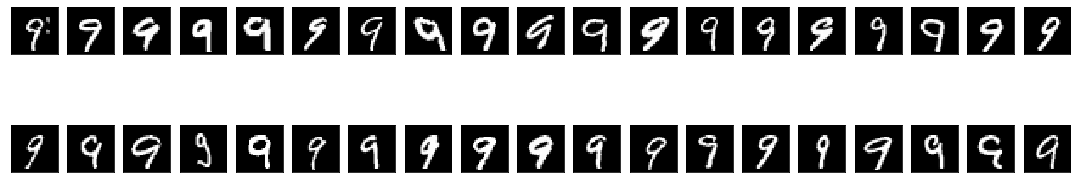

train label = 9 false_img


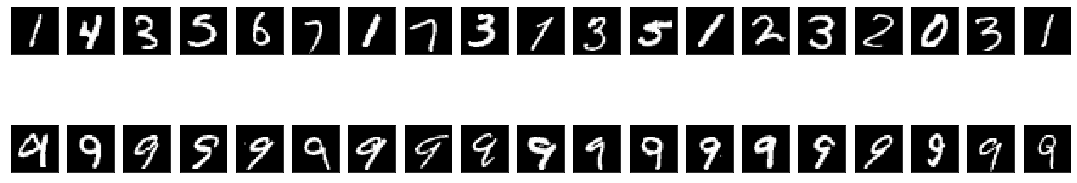

AUC: 0.8443248887032612
confusion_matrix:
[[3854 5137]
 [  55  954]]


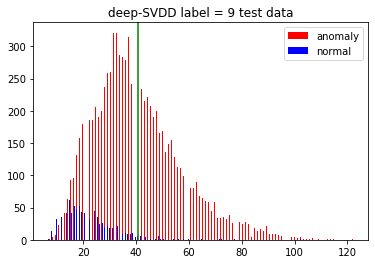

test label = 9 uncertain_img


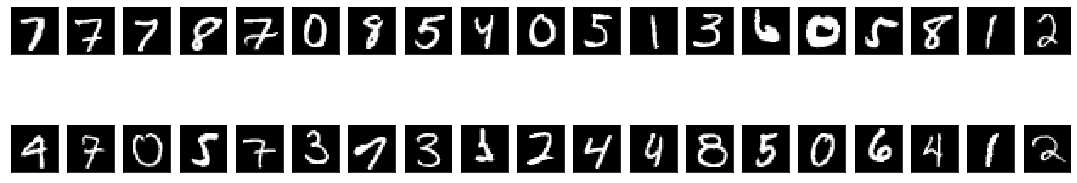

test label = 9 distance oder


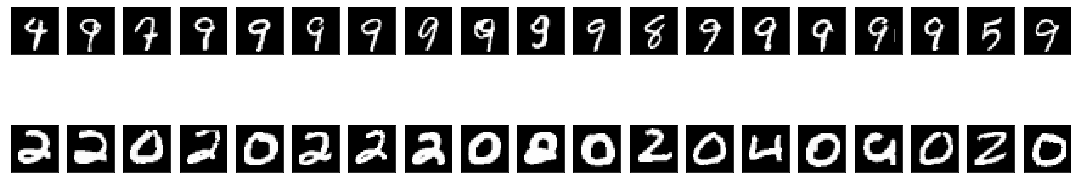

test label = 9 false_img


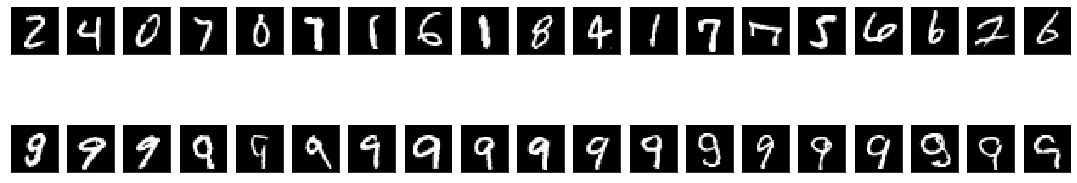

In [13]:
objective = 'deep-SVDD'
nu = 0.1
outlier_nu = 0.1
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [87]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [88]:
objective = 'deep-SVDD'
nu = 0.2
outlier_nu = 0.2
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)
result

auc =  0.8261786732431331
auc =  0.9828485530634506
auc =  0.697505644531115
auc =  0.7853415786517471
auc =  0.8183430604281366
auc =  0.7364451076371041
auc =  0.8575401316703909
auc =  0.8540775798810307
auc =  0.8024018907732214
auc =  0.8979357068774535


array([[ 0.        ,  0.        ,  0.82617867, 46.20369124],
       [ 1.        ,  0.        ,  0.98284855, 50.76946044],
       [ 2.        ,  0.        ,  0.69750564, 45.09527206],
       [ 3.        ,  0.        ,  0.78534158, 46.23793459],
       [ 4.        ,  0.        ,  0.81834306, 45.25201941],
       [ 5.        ,  0.        ,  0.73644511, 41.52673936],
       [ 6.        ,  0.        ,  0.85754013, 45.95151067],
       [ 7.        ,  0.        ,  0.85407758, 47.66378117],
       [ 8.        ,  0.        ,  0.80240189, 44.89574194],
       [ 9.        ,  0.        ,  0.89793571, 45.54930186]])

AUC: 0.866486973875295
confusion_matrix:
[[ 573  370]
 [ 565 4177]]


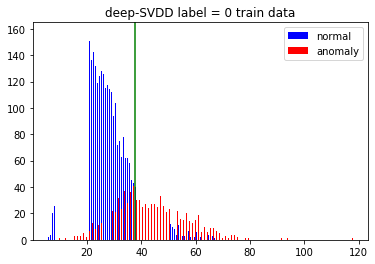

 train label = 0 uncertain_img


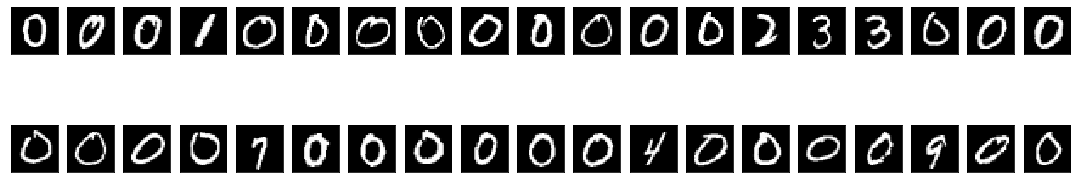

train label = 0 distance oder


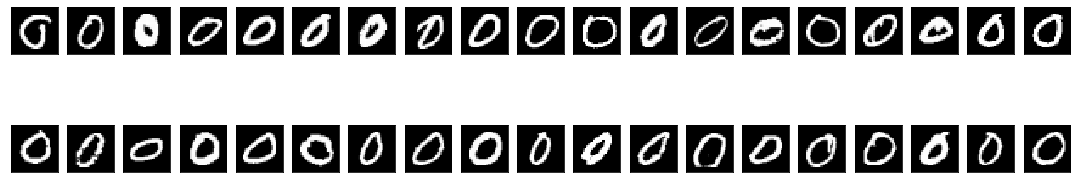

train label = 0 false_img


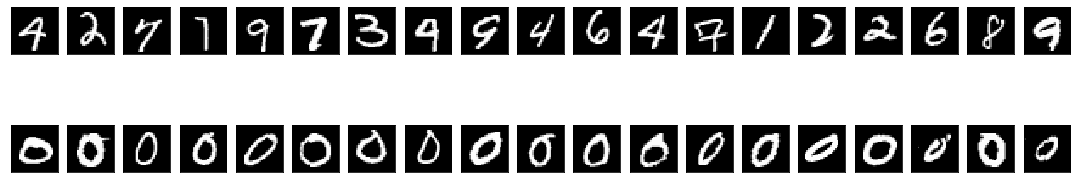

AUC: 0.8675011312729083
confusion_matrix:
[[5814 3206]
 [ 117  863]]


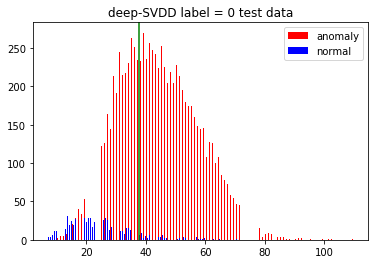

test label = 0 uncertain_img


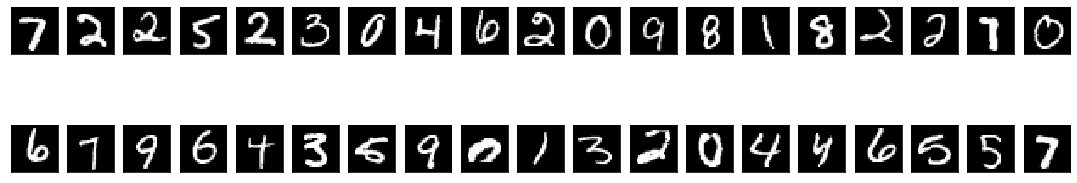

test label = 0 distance oder


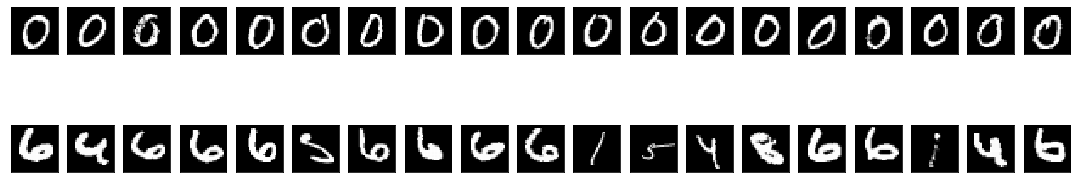

test label = 0 false_img


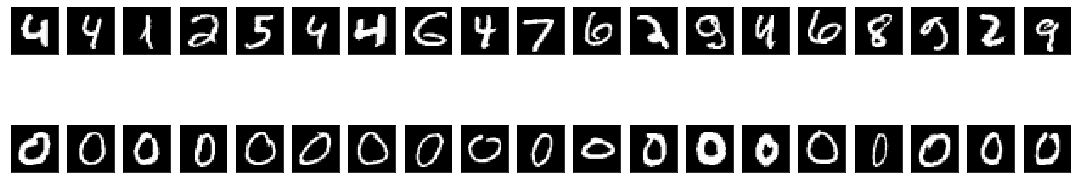

AUC: 0.8994592924402215
confusion_matrix:
[[ 803  273]
 [ 492 4904]]


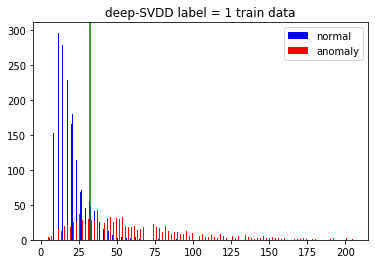

 train label = 1 uncertain_img


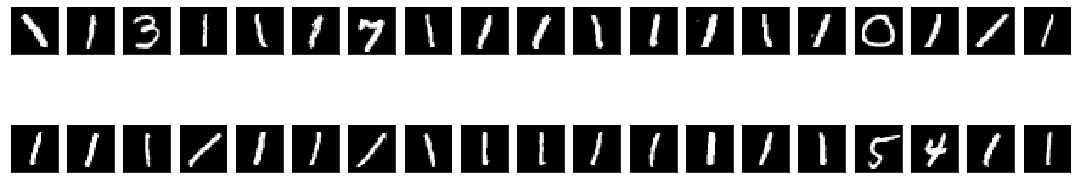

train label = 1 distance oder


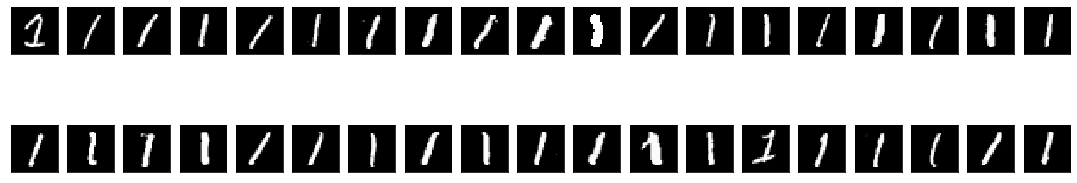

train label = 1 false_img


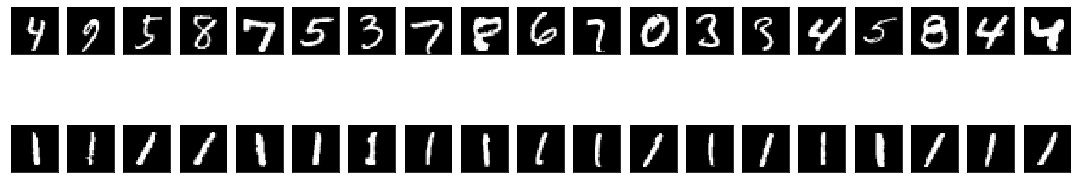

AUC: 0.9008873682824354
confusion_matrix:
[[6703 2162]
 [ 116 1019]]


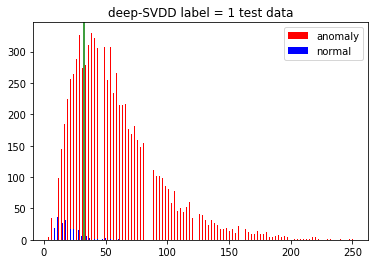

test label = 1 uncertain_img


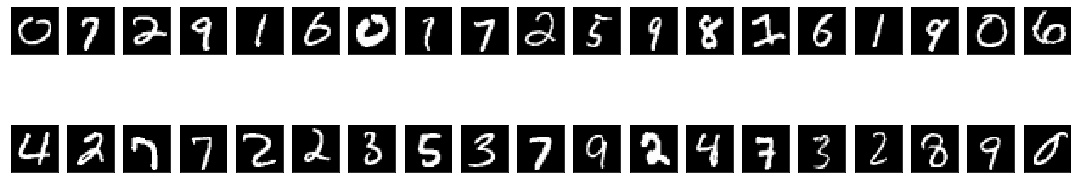

test label = 1 distance oder


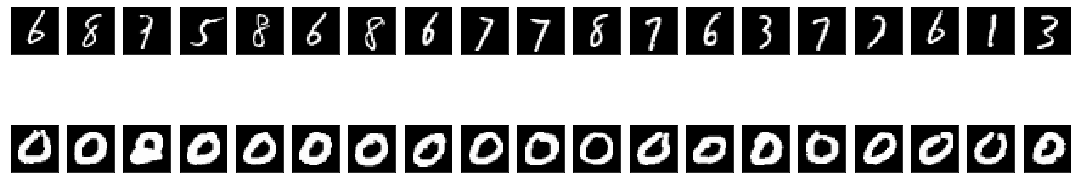

test label = 1 false_img


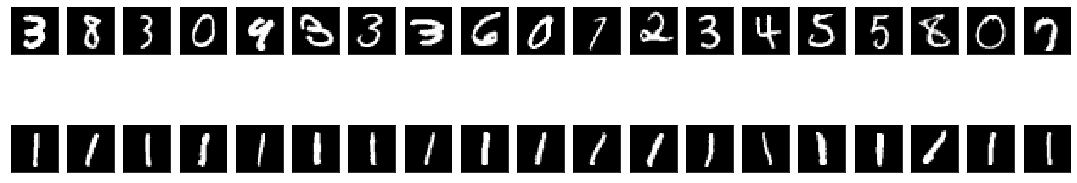

AUC: 0.7156282791330607
confusion_matrix:
[[ 375  574]
 [ 770 4000]]


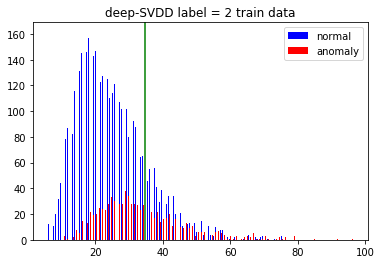

 train label = 2 uncertain_img


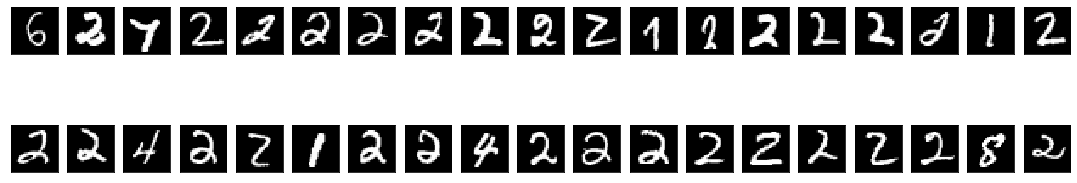

train label = 2 distance oder


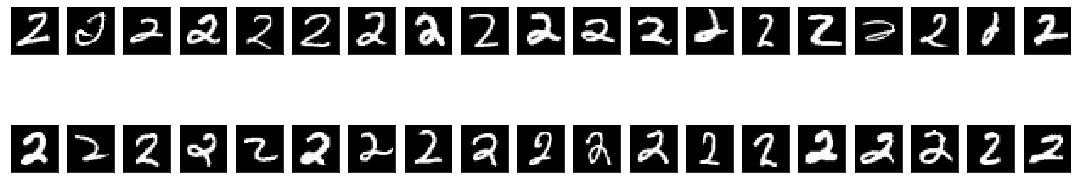

train label = 2 false_img


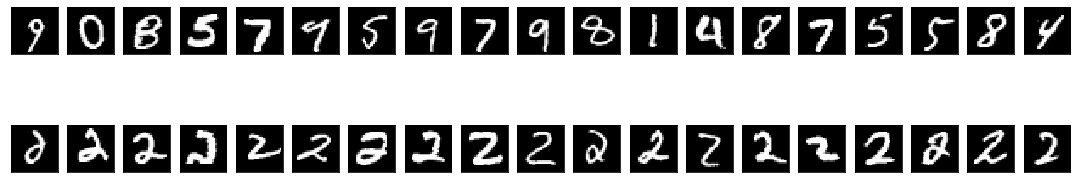

AUC: 0.7139100090589106
confusion_matrix:
[[3358 5610]
 [ 169  863]]


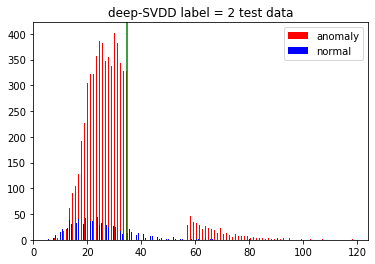

test label = 2 uncertain_img


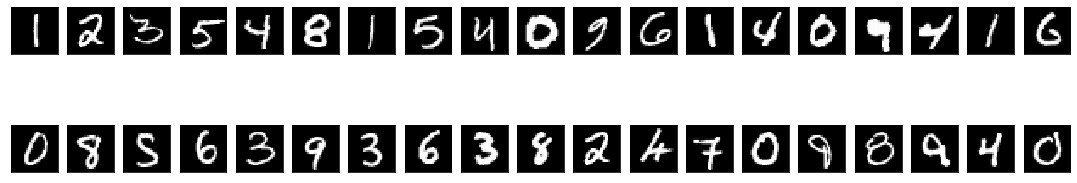

test label = 2 distance oder


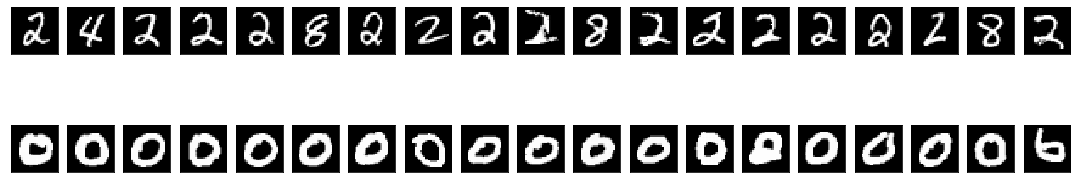

test label = 2 false_img


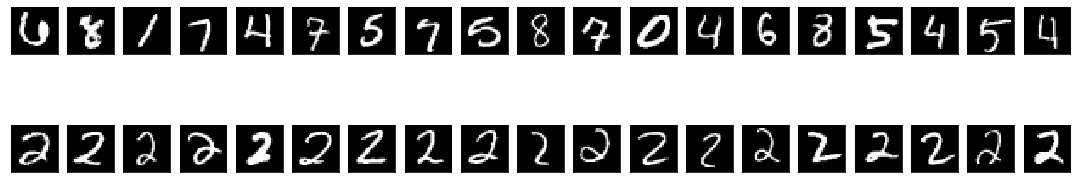

AUC: 0.7662863799954232
confusion_matrix:
[[ 437  543]
 [ 741 4164]]


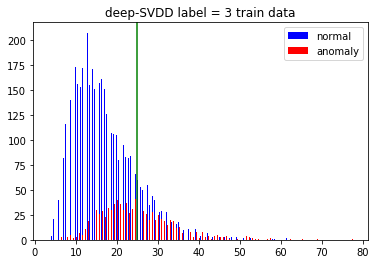

 train label = 3 uncertain_img


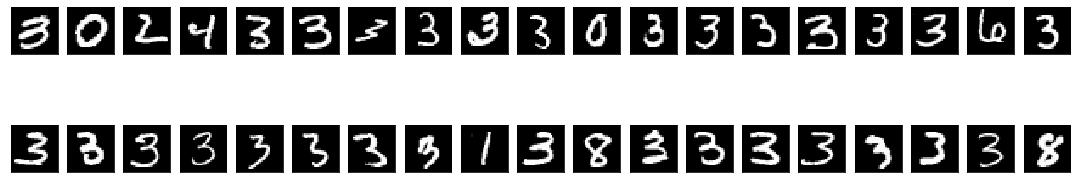

train label = 3 distance oder


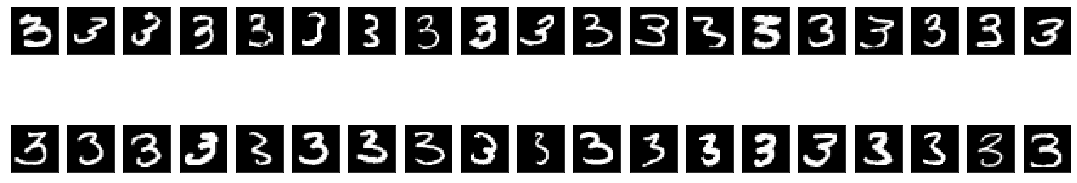

train label = 3 false_img


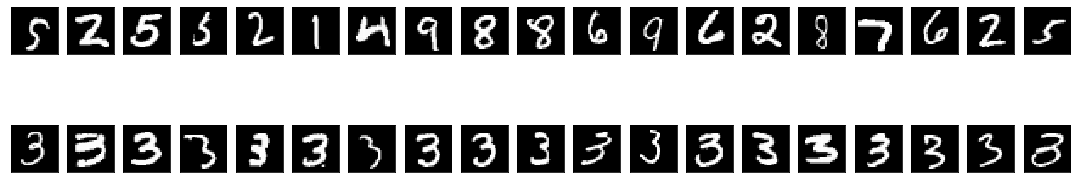

AUC: 0.7824691901893193
confusion_matrix:
[[3979 5011]
 [ 134  876]]


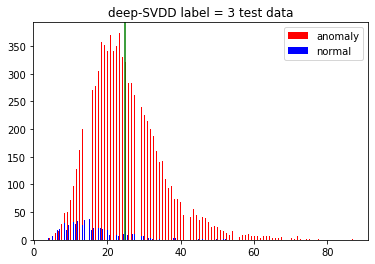

test label = 3 uncertain_img


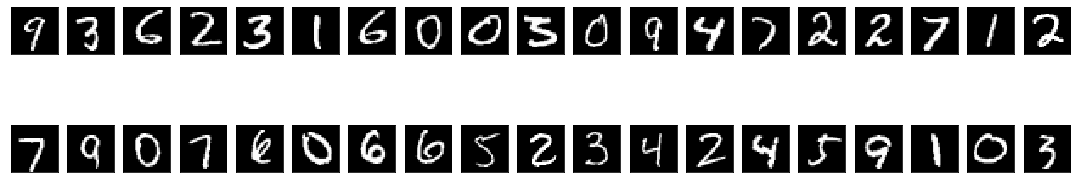

test label = 3 distance oder


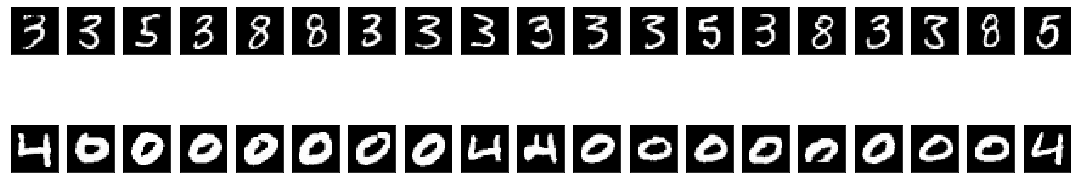

test label = 3 false_img


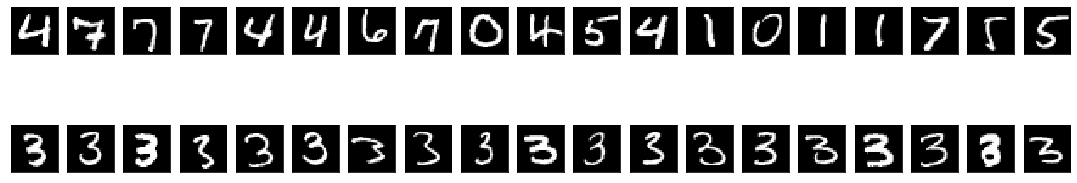

AUC: 0.780536108224398
confusion_matrix:
[[ 471  469]
 [ 651 4017]]


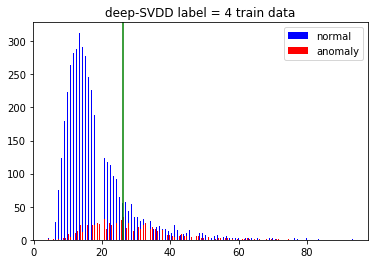

 train label = 4 uncertain_img


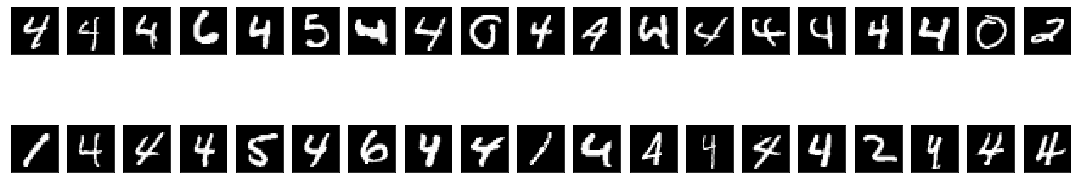

train label = 4 distance oder


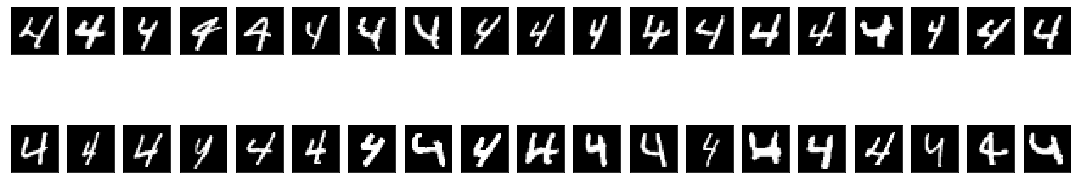

train label = 4 false_img


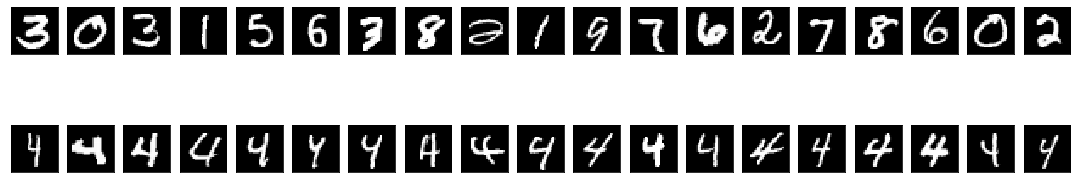

AUC: 0.7737010703643629
confusion_matrix:
[[4677 4341]
 [ 145  837]]


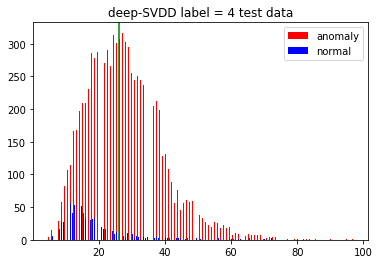

test label = 4 uncertain_img


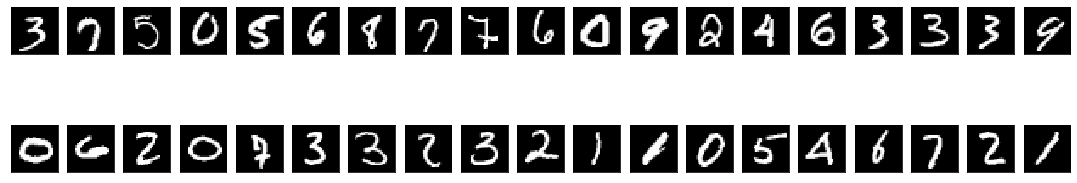

test label = 4 distance oder


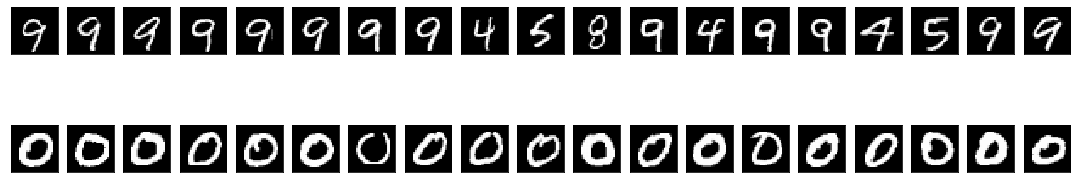

test label = 4 false_img


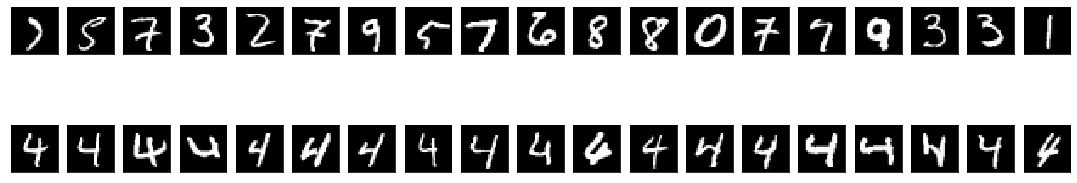

AUC: 0.6045038480137801
confusion_matrix:
[[ 251  614]
 [ 791 3548]]


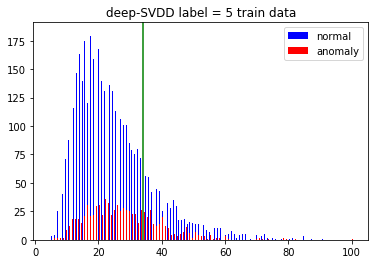

 train label = 5 uncertain_img


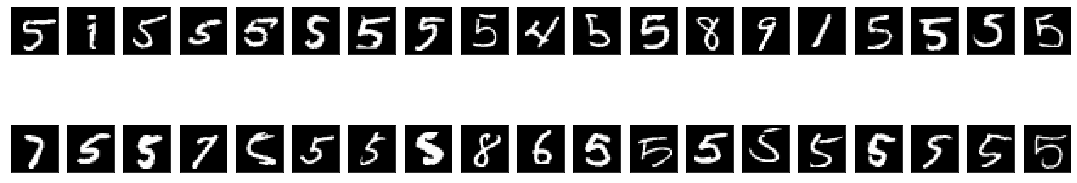

train label = 5 distance oder


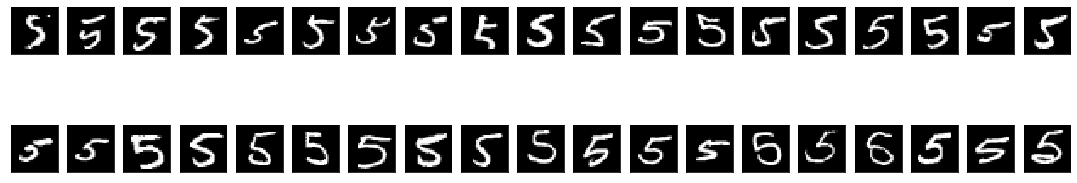

train label = 5 false_img


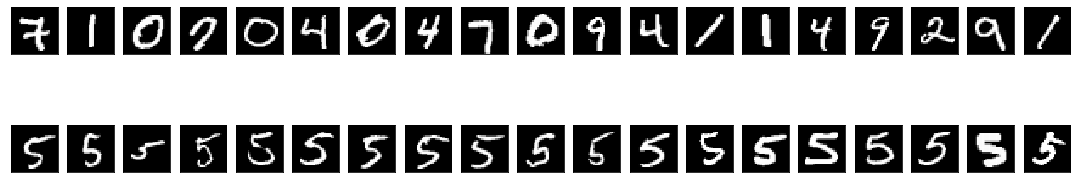

AUC: 0.5996120790671385
confusion_matrix:
[[2648 6460]
 [ 163  729]]


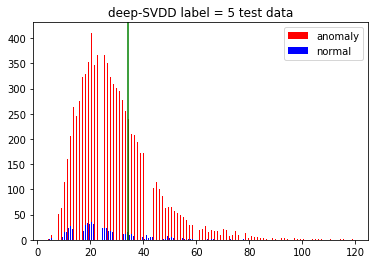

test label = 5 uncertain_img


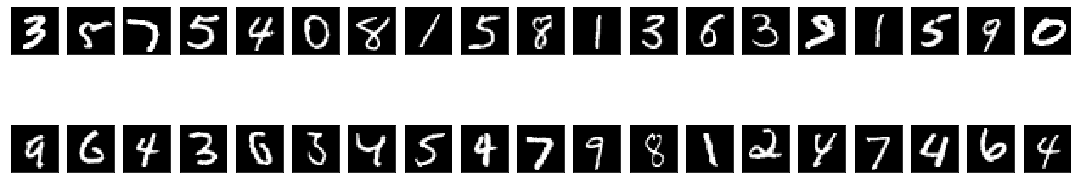

test label = 5 distance oder


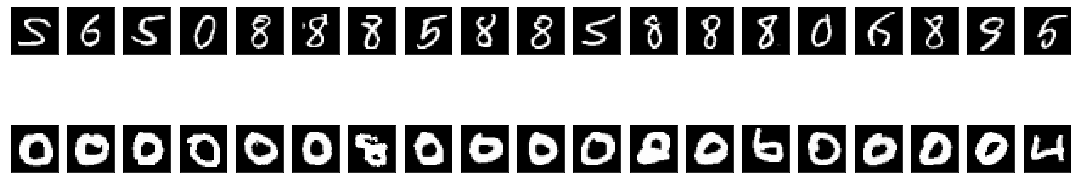

test label = 5 false_img


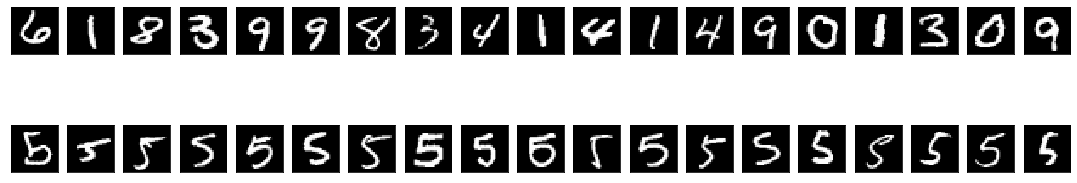

AUC: 0.7938455743580972
confusion_matrix:
[[ 456  507]
 [ 681 4036]]


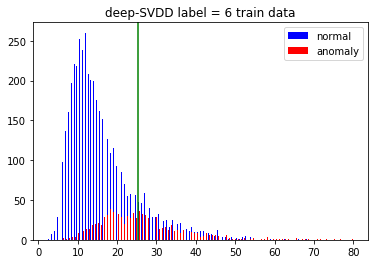

 train label = 6 uncertain_img


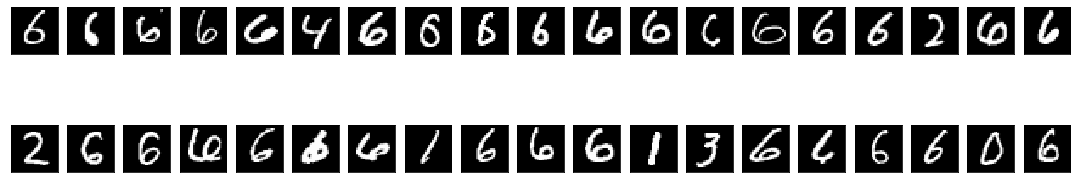

train label = 6 distance oder


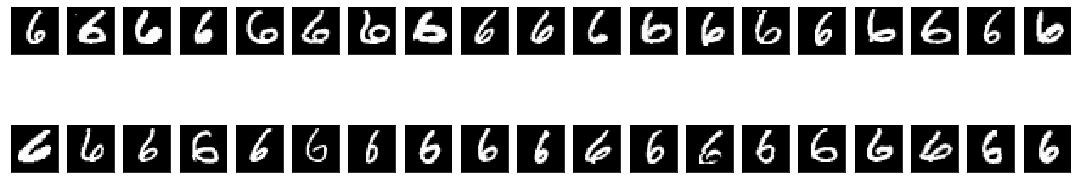

train label = 6 false_img


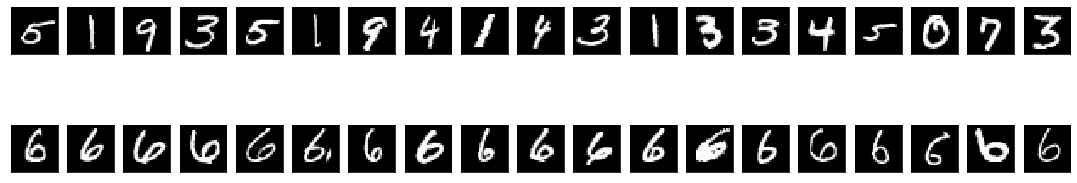

AUC: 0.7602044091156139
confusion_matrix:
[[4265 4777]
 [ 168  790]]


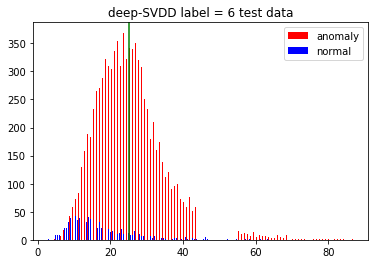

test label = 6 uncertain_img


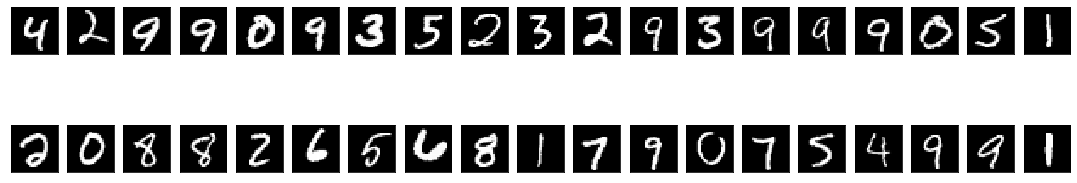

test label = 6 distance oder


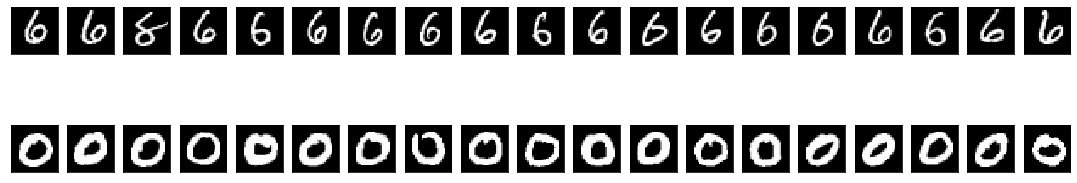

test label = 6 false_img


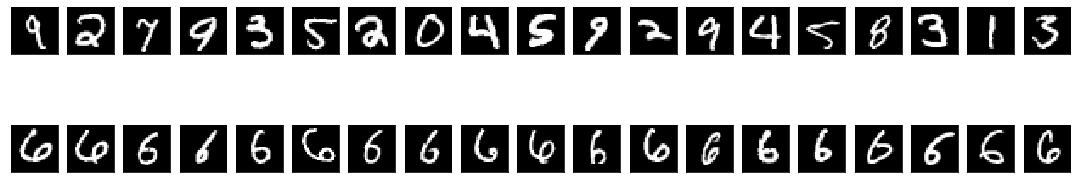

AUC: 0.7745696187927991
confusion_matrix:
[[ 470  542]
 [ 734 4268]]


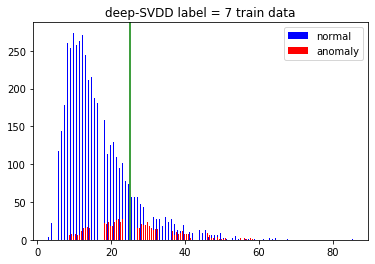

 train label = 7 uncertain_img


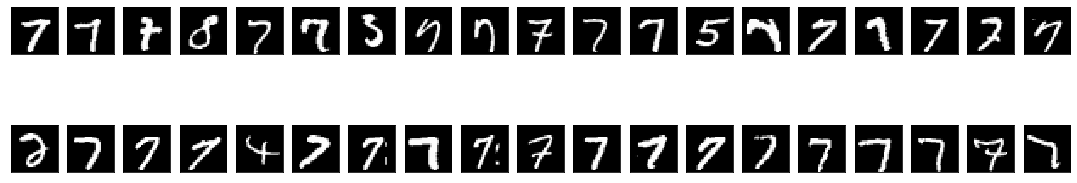

train label = 7 distance oder


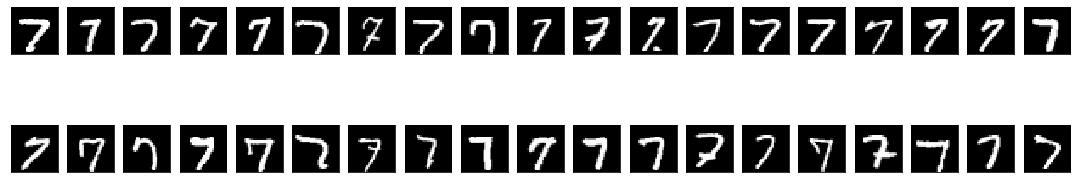

train label = 7 false_img


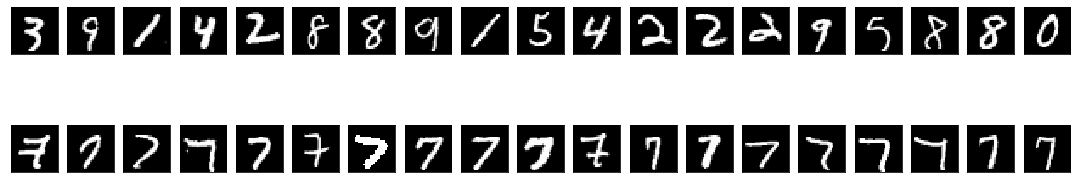

AUC: 0.7653185179659676
confusion_matrix:
[[4231 4741]
 [ 160  868]]


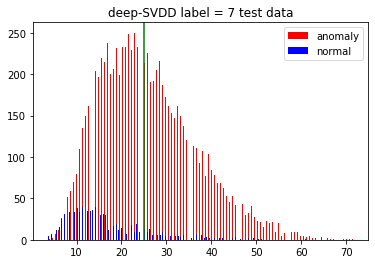

test label = 7 uncertain_img


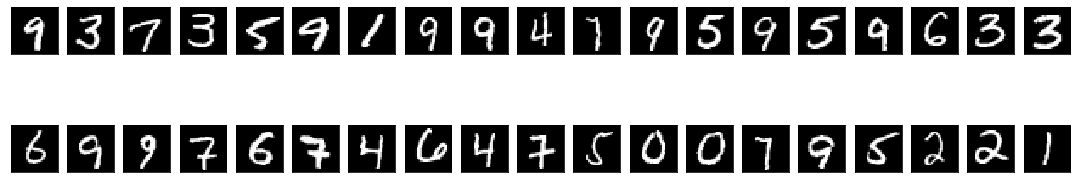

test label = 7 distance oder


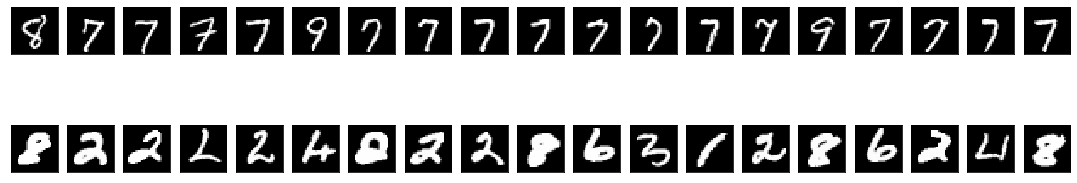

test label = 7 false_img


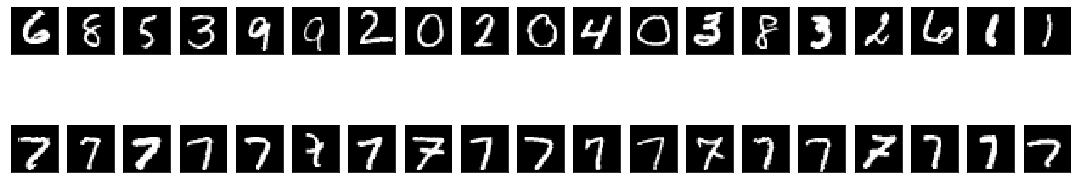

AUC: 0.8206098871909191
confusion_matrix:
[[ 483  462]
 [ 641 4030]]


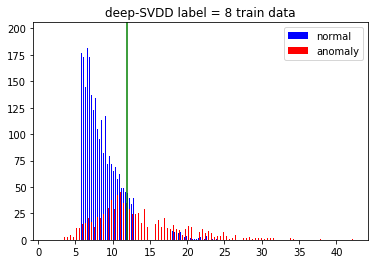

 train label = 8 uncertain_img


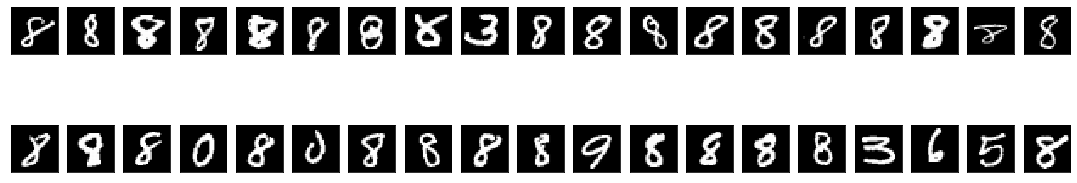

train label = 8 distance oder


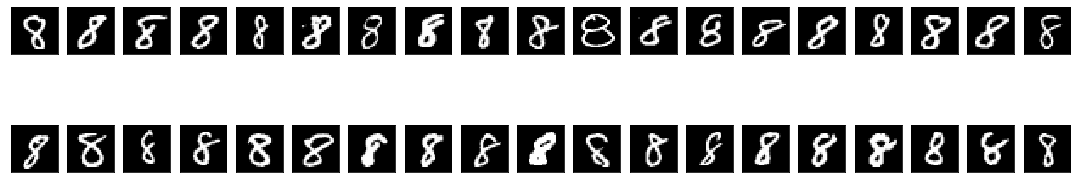

train label = 8 false_img


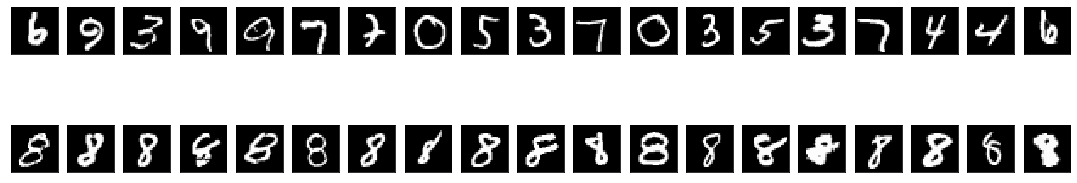

AUC: 0.8435942071979148
confusion_matrix:
[[4809 4217]
 [ 104  870]]


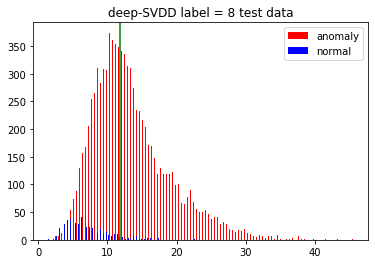

test label = 8 uncertain_img


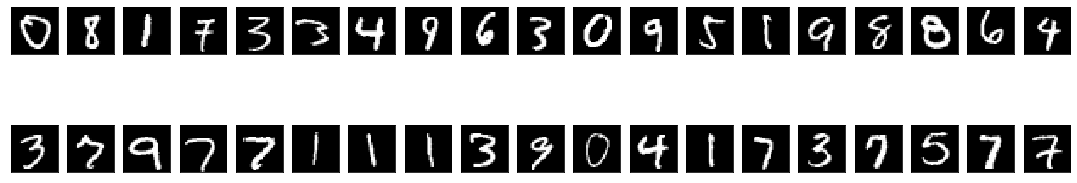

test label = 8 distance oder


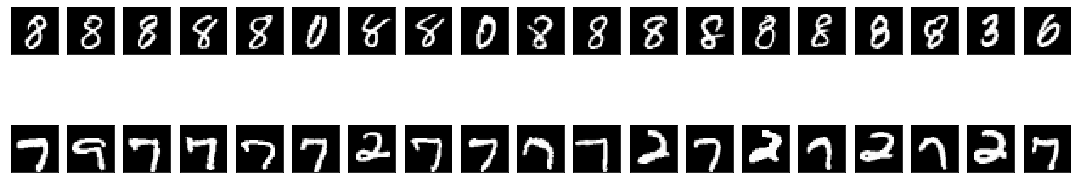

test label = 8 false_img


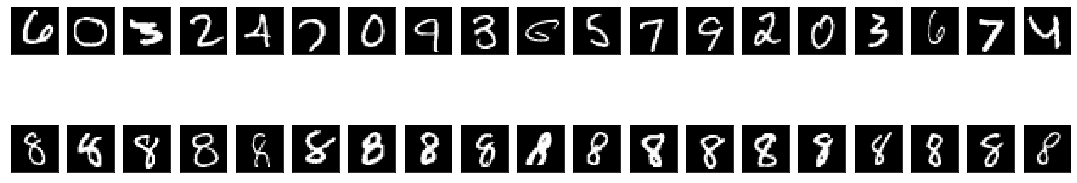

AUC: 0.8227246222719519
confusion_matrix:
[[ 536  415]
 [ 607 4152]]


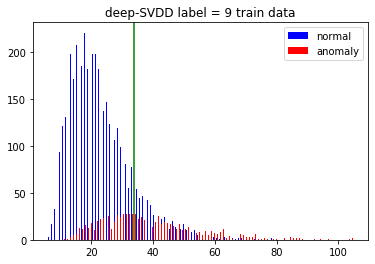

 train label = 9 uncertain_img


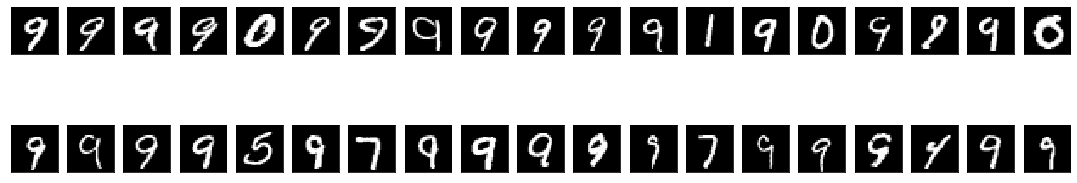

train label = 9 distance oder


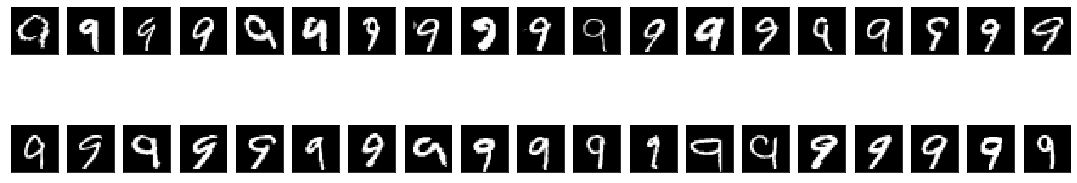

train label = 9 false_img


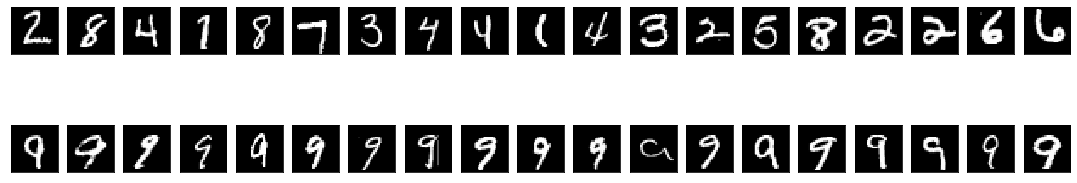

AUC: 0.8315506344357793
confusion_matrix:
[[5184 3807]
 [ 118  891]]


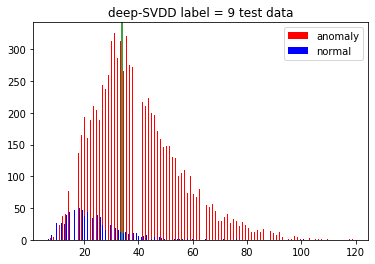

test label = 9 uncertain_img


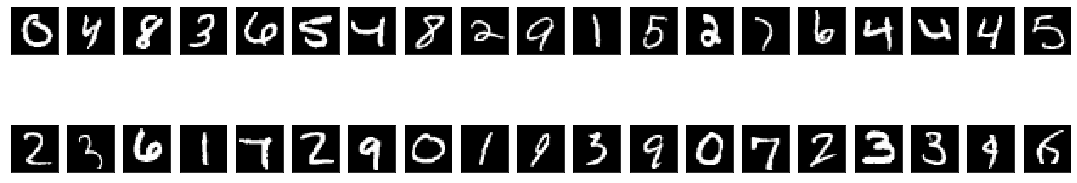

test label = 9 distance oder


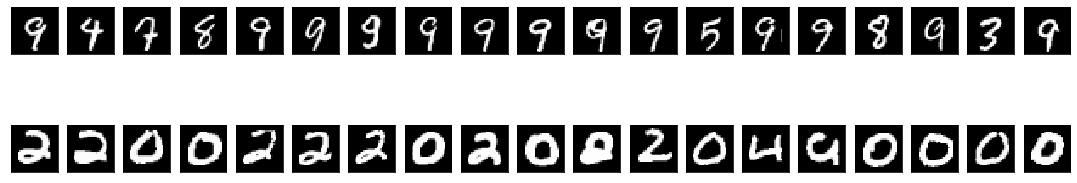

test label = 9 false_img


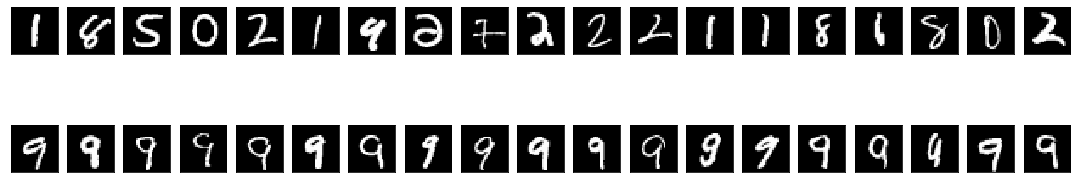

In [15]:
objective = 'deep-SVDD'
nu = 0.2
outlier_nu = 0.2
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [96]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [97]:
objective = 'deep-SVDD'
nu = 0.3
outlier_nu = 0.3
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)
result

auc =  0.7847670709081859
auc =  0.9773223909300297
auc =  0.6562331982276345
auc =  0.7480782277337856
auc =  0.7886314946481782
auc =  0.67634536533201
auc =  0.8155389670750138
auc =  0.8262595172876792
auc =  0.7849551444128323
auc =  0.8756014025257499


array([[ 0.        ,  0.        ,  0.78476707, 48.05188608],
       [ 1.        ,  0.        ,  0.97732239, 54.22320724],
       [ 2.        ,  0.        ,  0.6562332 , 48.18705535],
       [ 3.        ,  0.        ,  0.74807823, 49.95162559],
       [ 4.        ,  0.        ,  0.78863149, 48.63209605],
       [ 5.        ,  0.        ,  0.67634537, 44.94713092],
       [ 6.        ,  0.        ,  0.81553897, 48.86584783],
       [ 7.        ,  0.        ,  0.82625952, 52.18863487],
       [ 8.        ,  0.        ,  0.78495514, 49.25299287],
       [ 9.        ,  0.        ,  0.8756014 , 48.92172027]])

AUC: 0.8209243238027851
confusion_matrix:
[[ 927  489]
 [ 921 3822]]


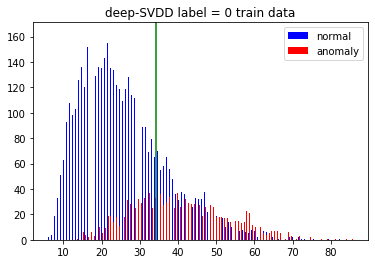

 train label = 0 uncertain_img


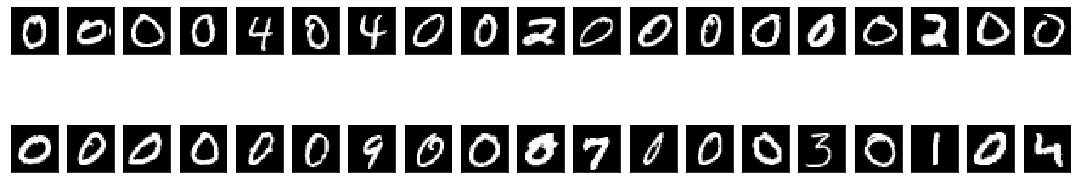

train label = 0 distance oder


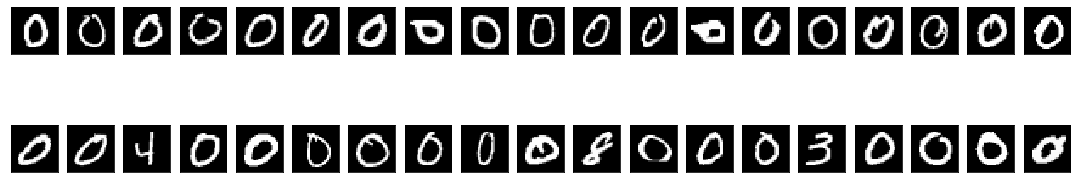

train label = 0 false_img


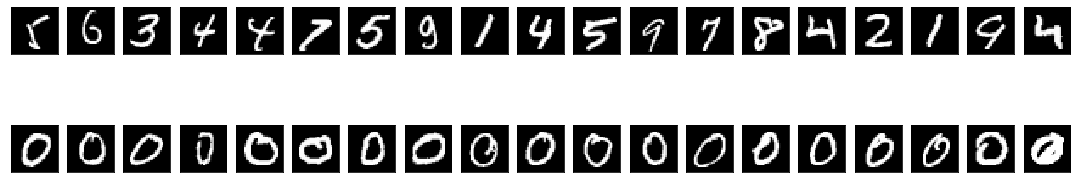

AUC: 0.8167594687542423
confusion_matrix:
[[5889 3131]
 [ 194  786]]


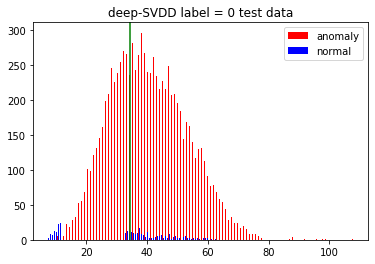

test label = 0 uncertain_img


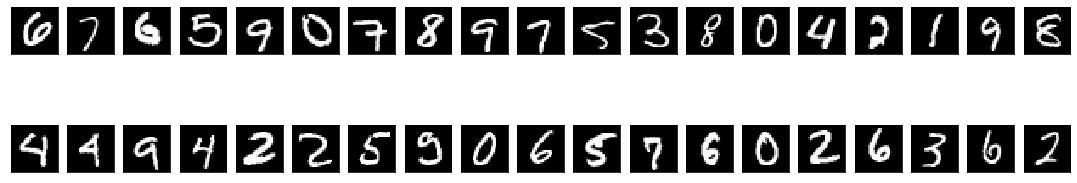

test label = 0 distance oder


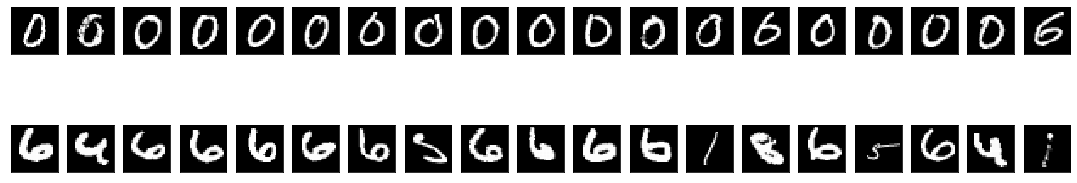

test label = 0 false_img


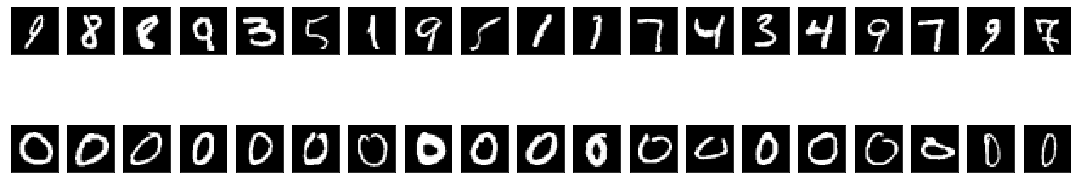

AUC: 0.8756590853185144
confusion_matrix:
[[1275  349]
 [ 829 4558]]


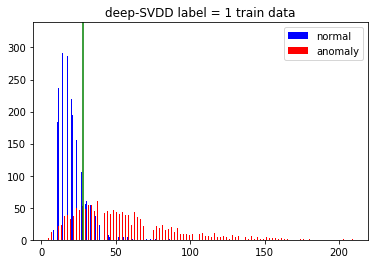

 train label = 1 uncertain_img


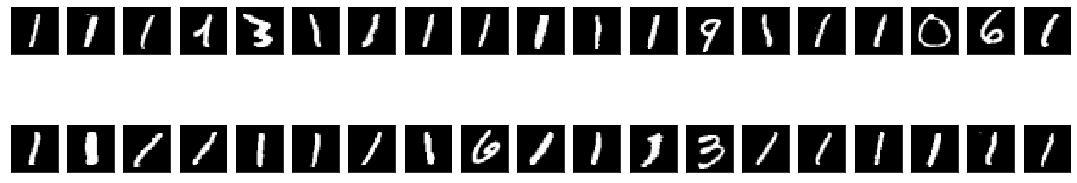

train label = 1 distance oder


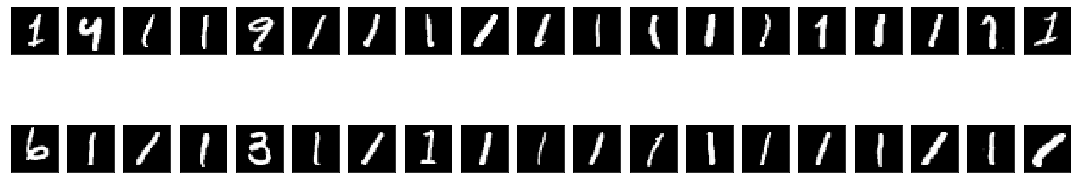

train label = 1 false_img


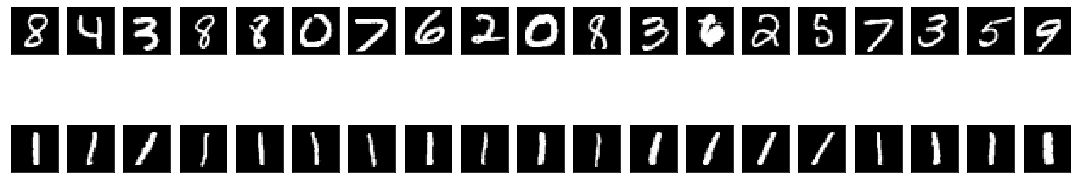

AUC: 0.8719946530309016
confusion_matrix:
[[6921 1944]
 [ 181  954]]


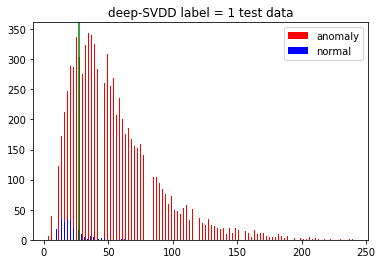

test label = 1 uncertain_img


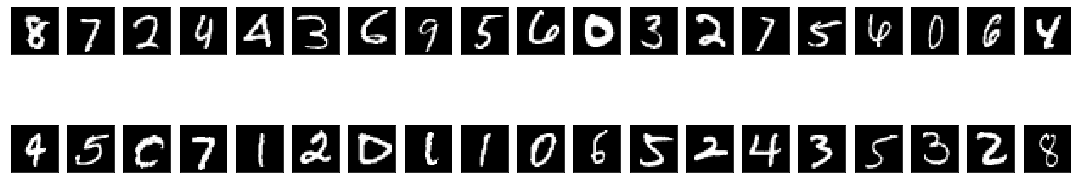

test label = 1 distance oder


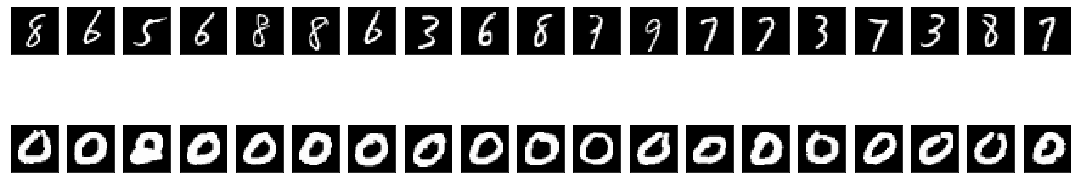

test label = 1 false_img


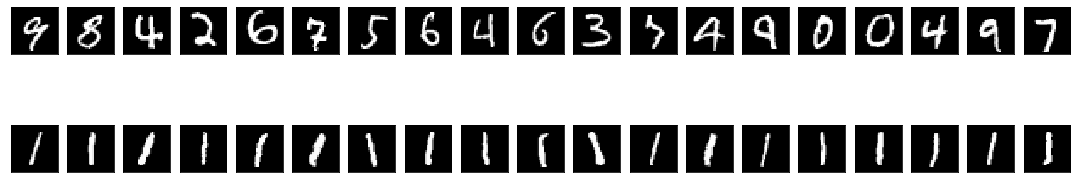

AUC: 0.6819595575118403
confusion_matrix:
[[ 664  779]
 [1196 3557]]


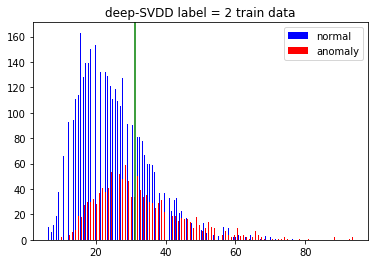

 train label = 2 uncertain_img


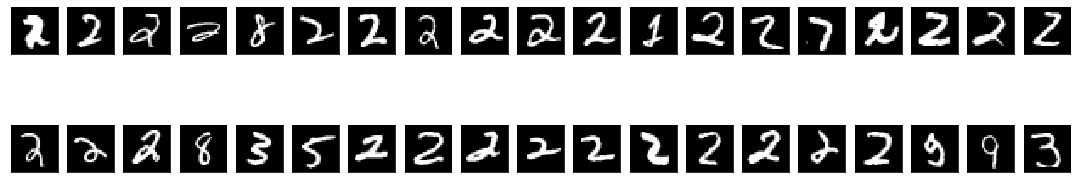

train label = 2 distance oder


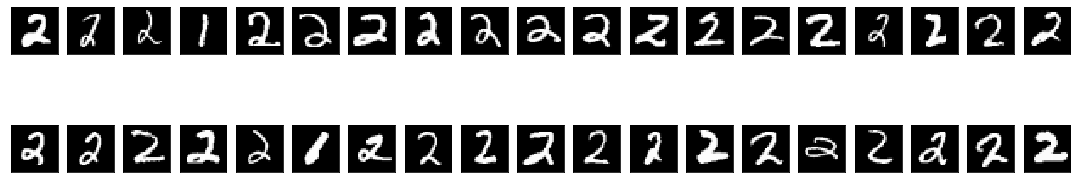

train label = 2 false_img


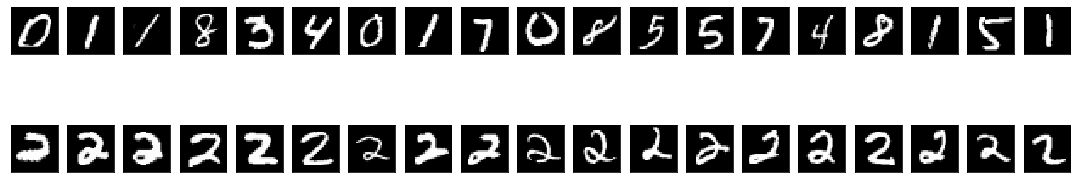

AUC: 0.6812730254513896
confusion_matrix:
[[4101 4867]
 [ 241  791]]


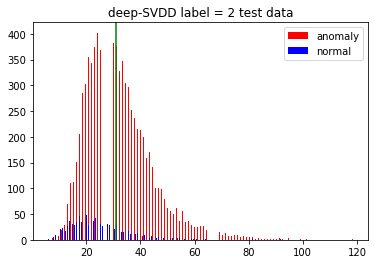

test label = 2 uncertain_img


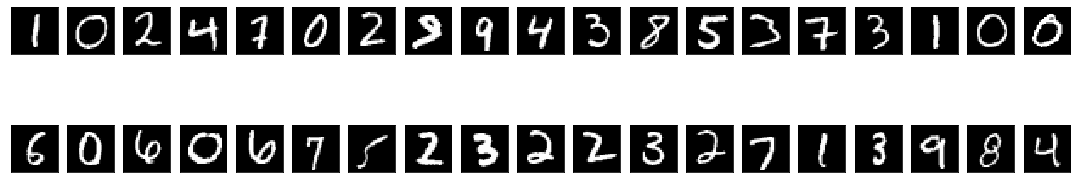

test label = 2 distance oder


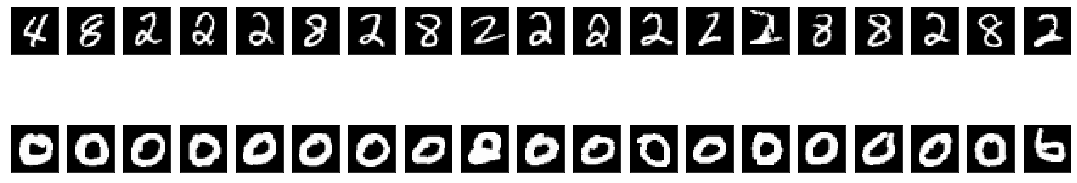

test label = 2 false_img


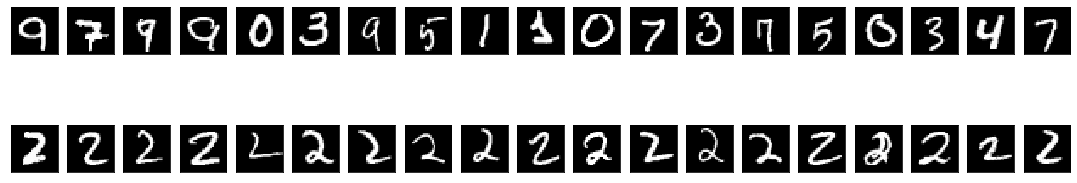

AUC: 0.7305215371621622
confusion_matrix:
[[ 811  669]
 [1103 3793]]


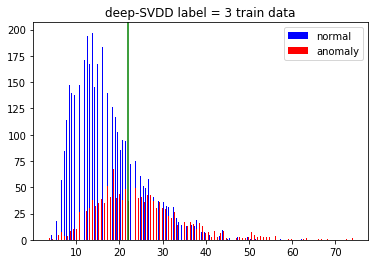

 train label = 3 uncertain_img


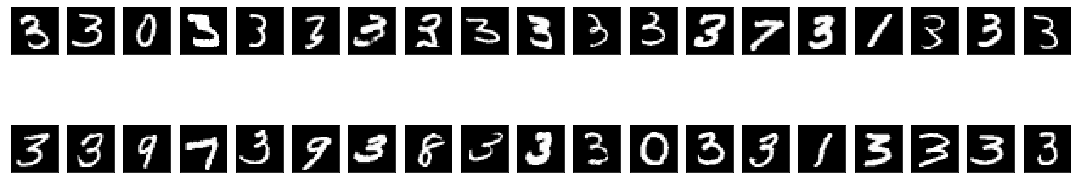

train label = 3 distance oder


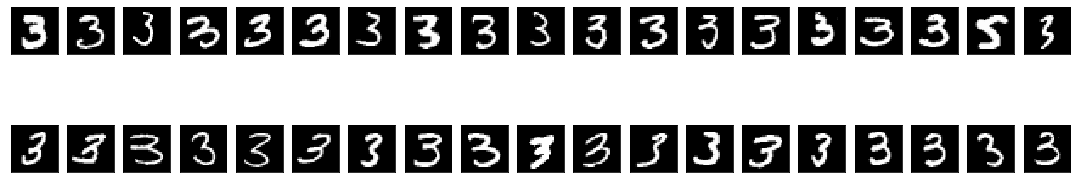

train label = 3 false_img


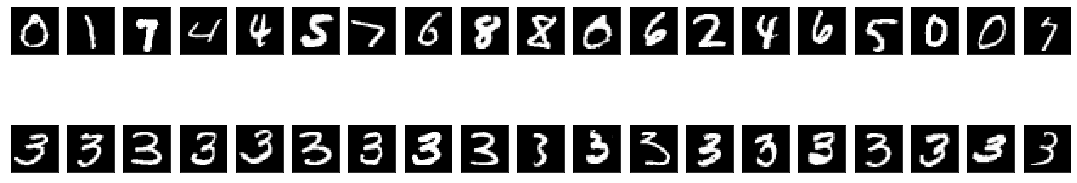

AUC: 0.7561209925219441
confusion_matrix:
[[4763 4227]
 [ 189  821]]


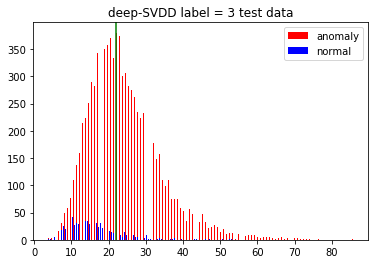

test label = 3 uncertain_img


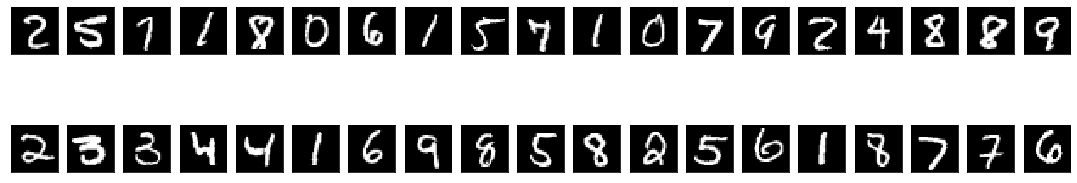

test label = 3 distance oder


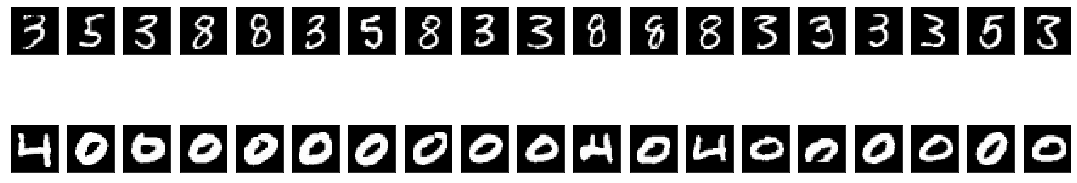

test label = 3 false_img


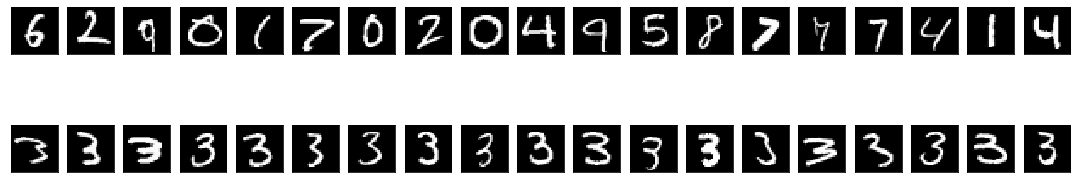

AUC: 0.7588463277780408
confusion_matrix:
[[ 861  565]
 [ 961 3688]]


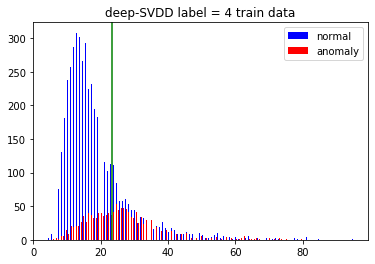

 train label = 4 uncertain_img


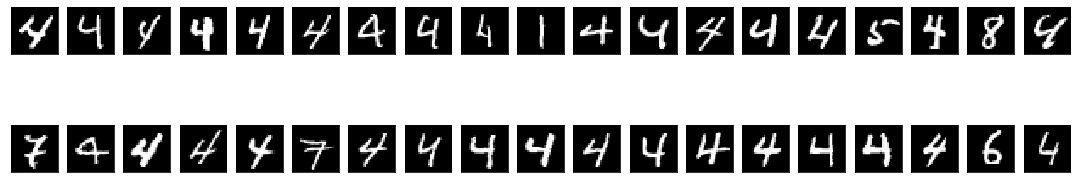

train label = 4 distance oder


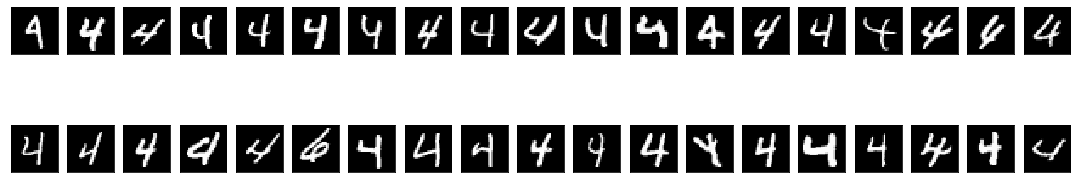

train label = 4 false_img


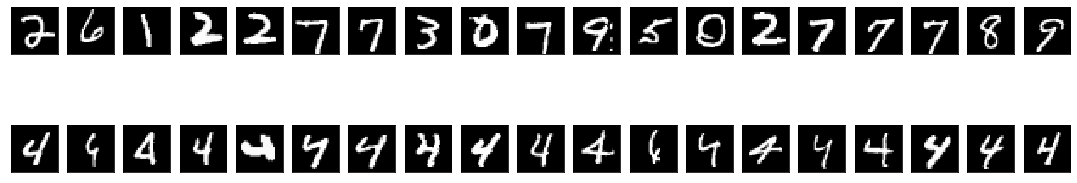

AUC: 0.7516225751709977
confusion_matrix:
[[5366 3652]
 [ 208  774]]


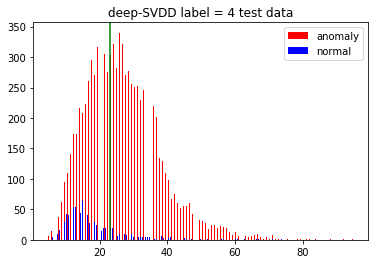

test label = 4 uncertain_img


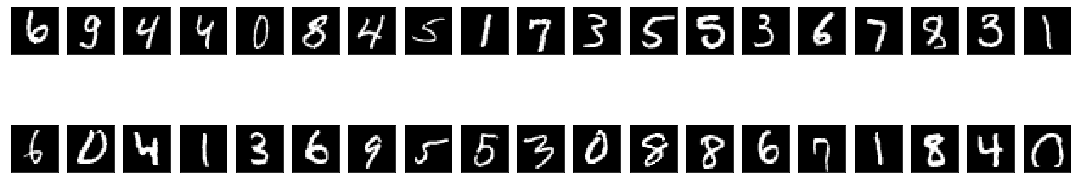

test label = 4 distance oder


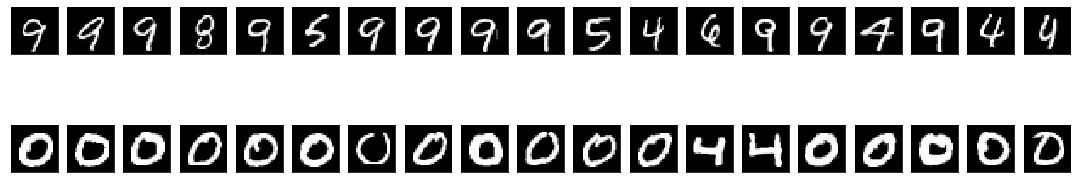

test label = 4 false_img


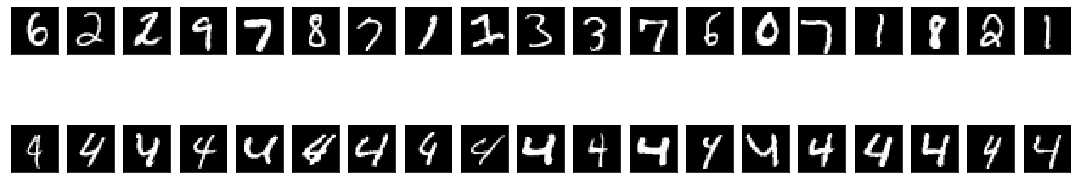

AUC: 0.5931067568307797
confusion_matrix:
[[ 518  789]
 [1173 3157]]


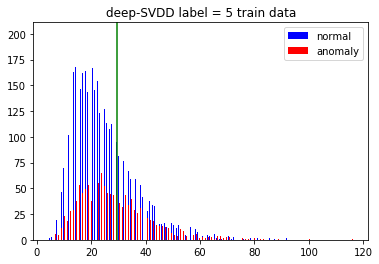

 train label = 5 uncertain_img


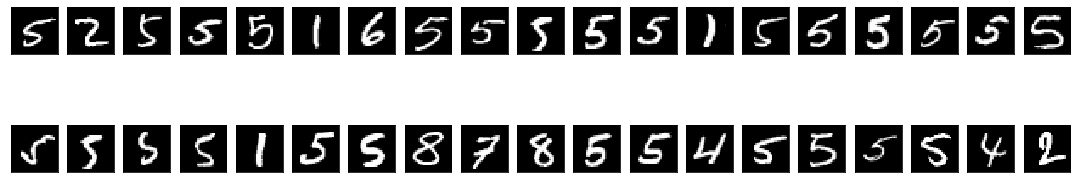

train label = 5 distance oder


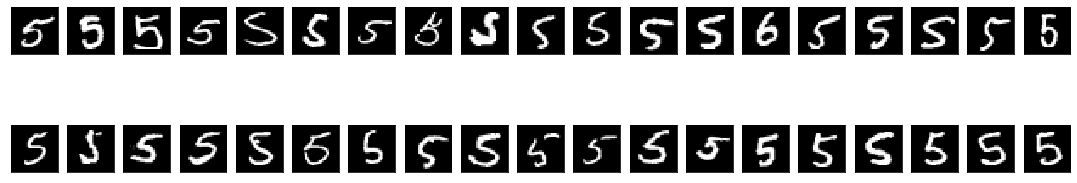

train label = 5 false_img


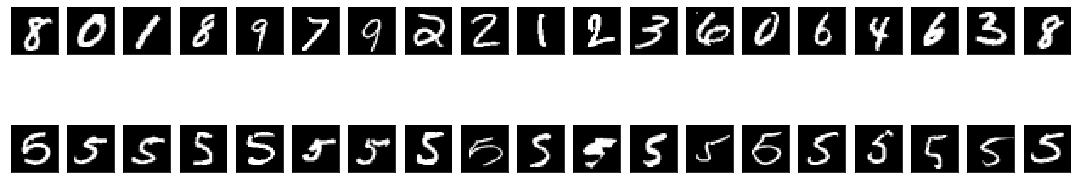

AUC: 0.5855452679455897
confusion_matrix:
[[3597 5511]
 [ 250  642]]


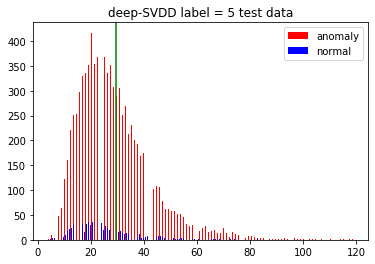

test label = 5 uncertain_img


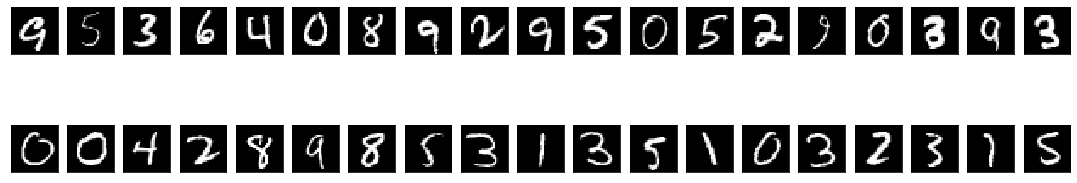

test label = 5 distance oder


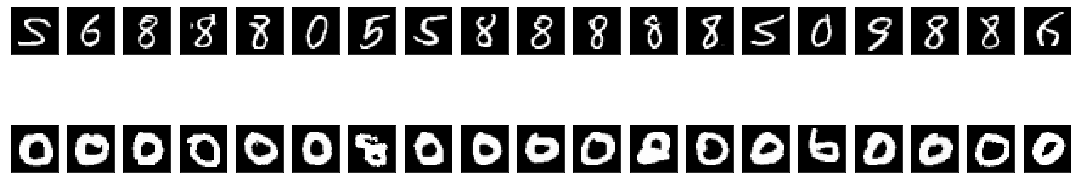

test label = 5 false_img


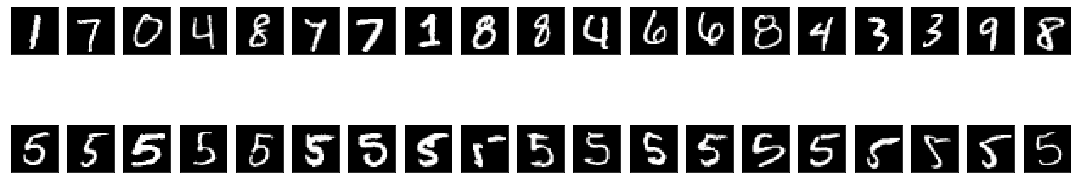

AUC: 0.7774008697273425
confusion_matrix:
[[ 859  580]
 [ 988 3727]]


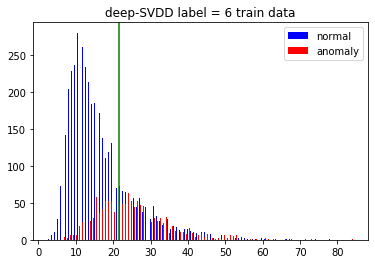

 train label = 6 uncertain_img


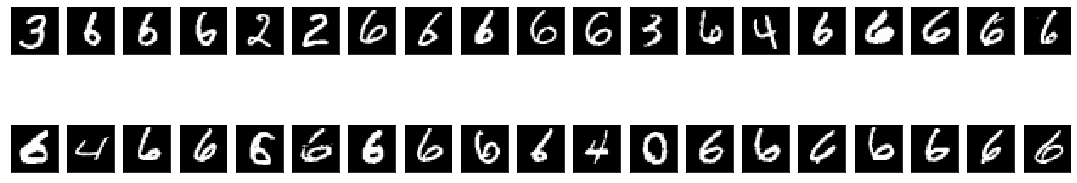

train label = 6 distance oder


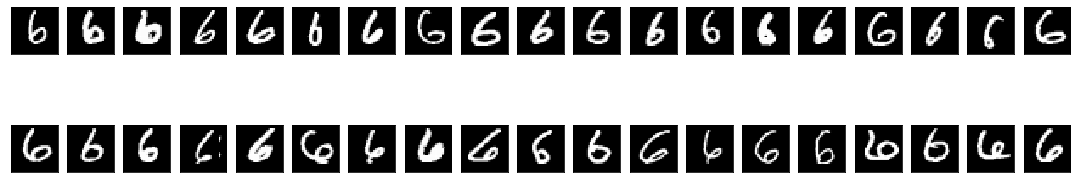

train label = 6 false_img


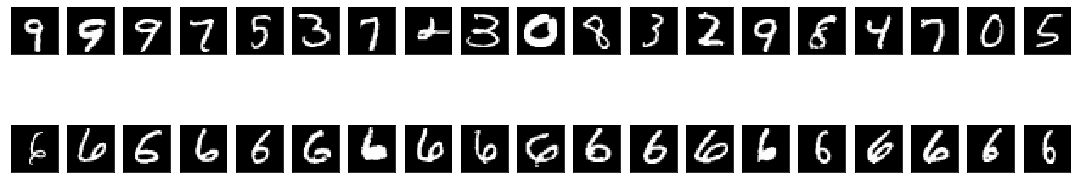

AUC: 0.7319289153516483
confusion_matrix:
[[5372 3670]
 [ 254  704]]


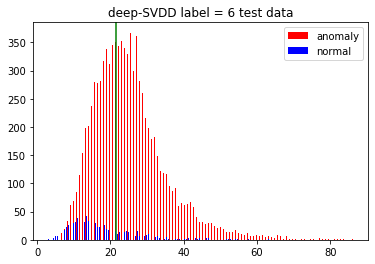

test label = 6 uncertain_img


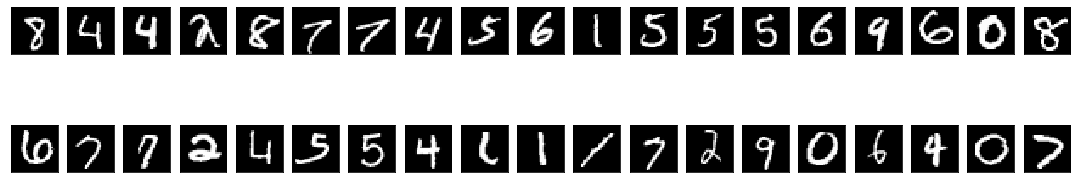

test label = 6 distance oder


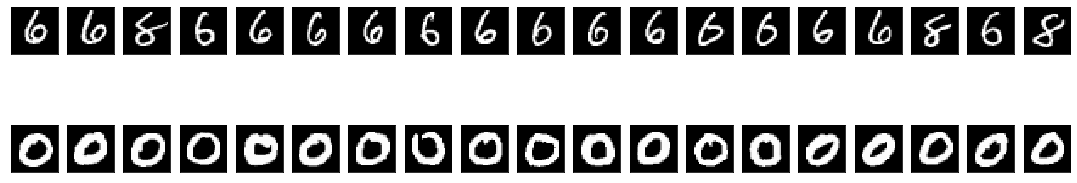

test label = 6 false_img


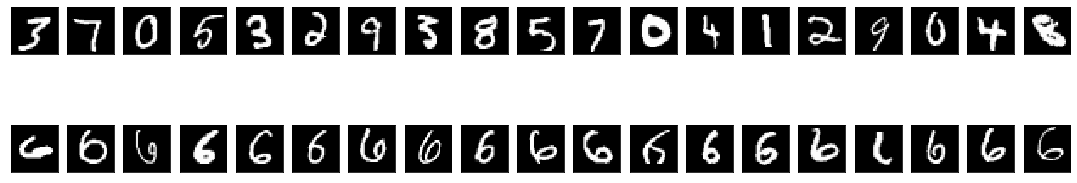

AUC: 0.7518374994654378
confusion_matrix:
[[ 865  637]
 [1090 3923]]


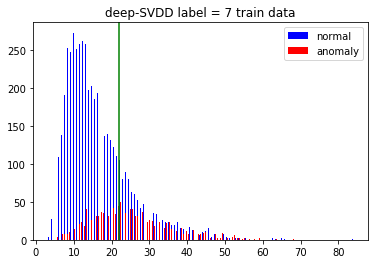

 train label = 7 uncertain_img


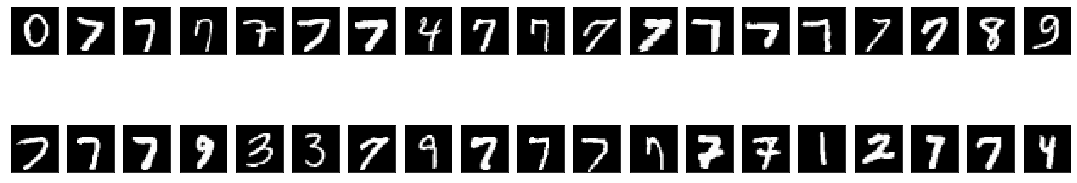

train label = 7 distance oder


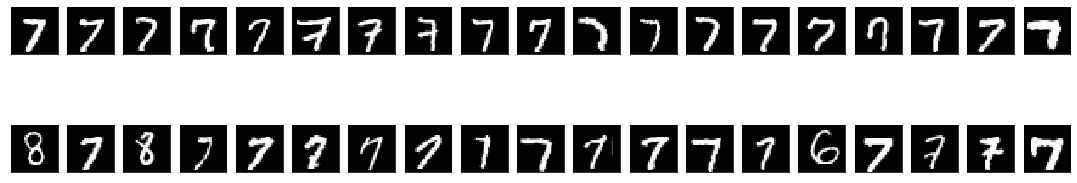

train label = 7 false_img


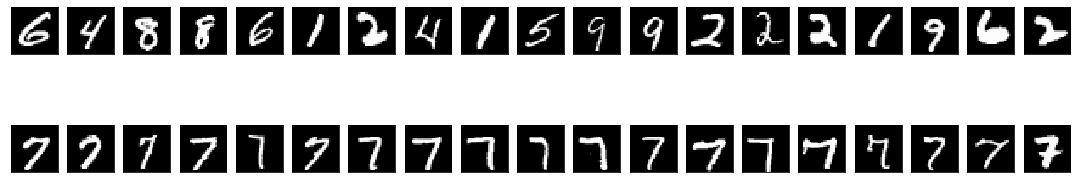

AUC: 0.7458155593450267
confusion_matrix:
[[5043 3929]
 [ 247  781]]


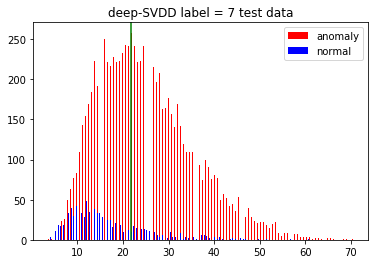

test label = 7 uncertain_img


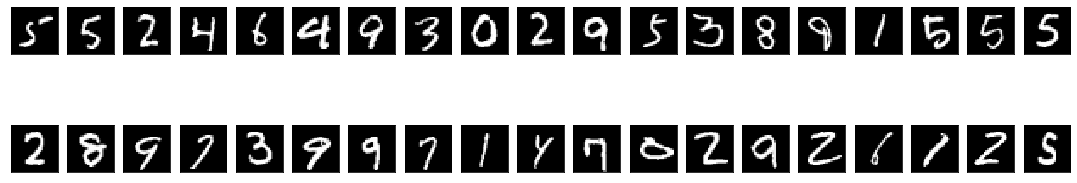

test label = 7 distance oder


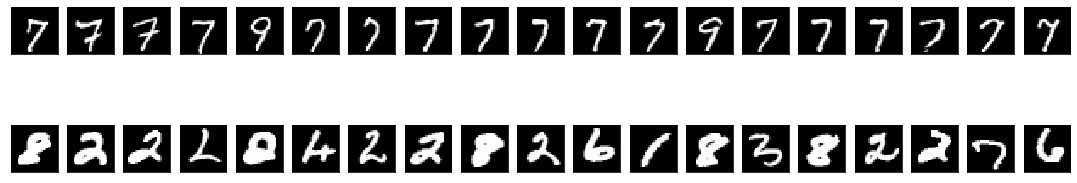

test label = 7 false_img


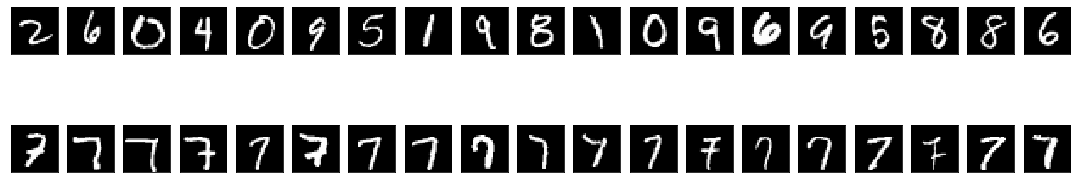

AUC: 0.7994525320393182
confusion_matrix:
[[ 873  537]
 [ 953 3721]]


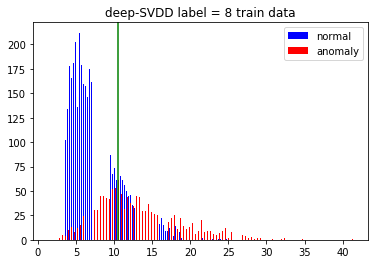

 train label = 8 uncertain_img


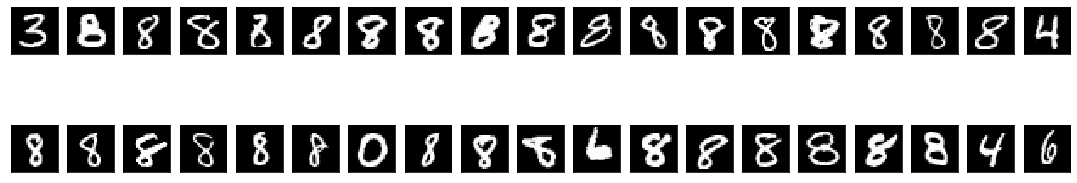

train label = 8 distance oder


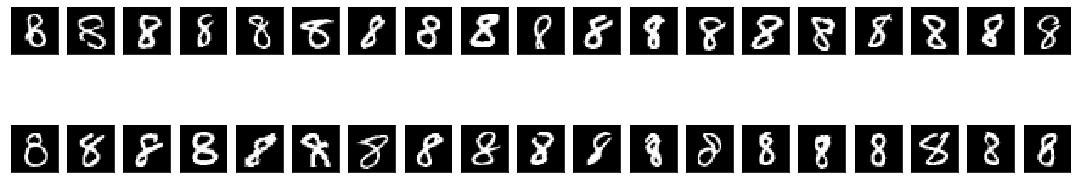

train label = 8 false_img


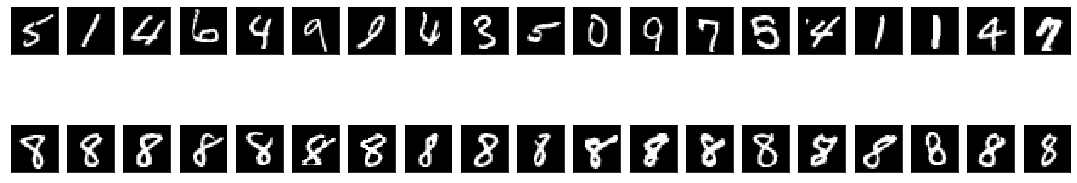

AUC: 0.8310305137201177
confusion_matrix:
[[5771 3255]
 [ 162  812]]


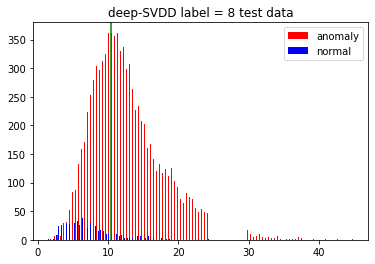

test label = 8 uncertain_img


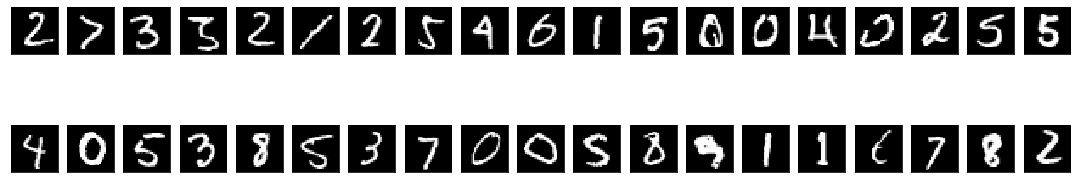

test label = 8 distance oder


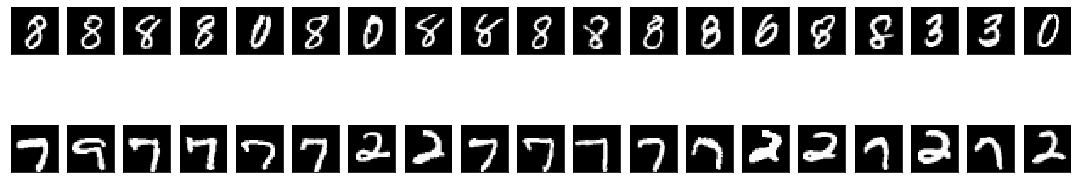

test label = 8 false_img


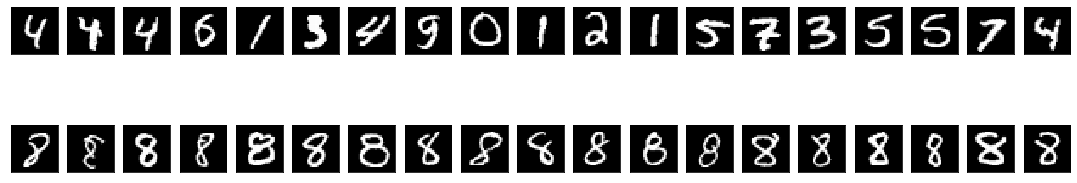

AUC: 0.8094762890599727
confusion_matrix:
[[ 929  501]
 [ 927 3829]]


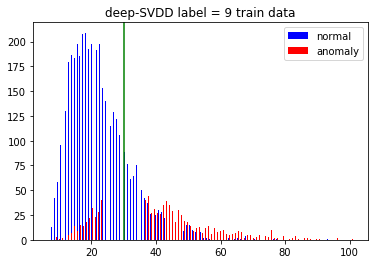

 train label = 9 uncertain_img


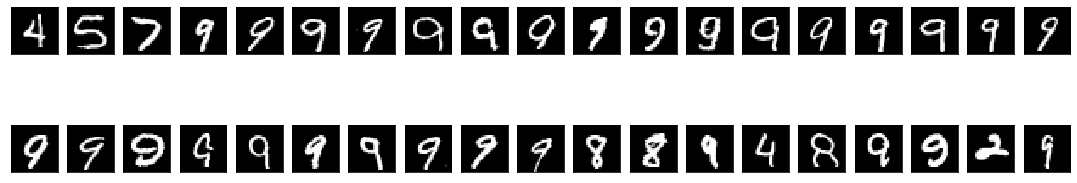

train label = 9 distance oder


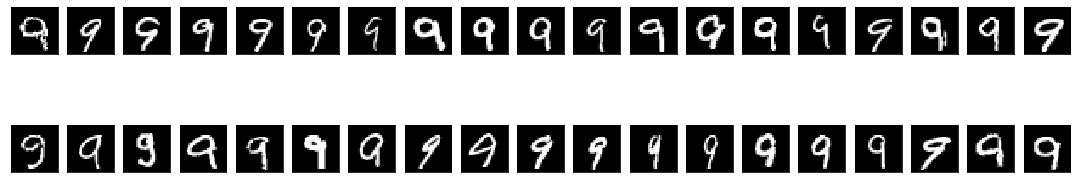

train label = 9 false_img


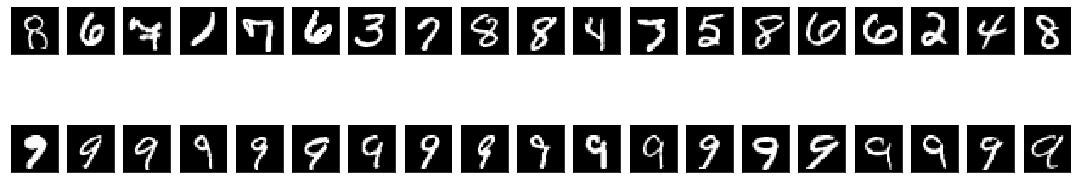

AUC: 0.8186146723752714
confusion_matrix:
[[6019 2972]
 [ 186  823]]


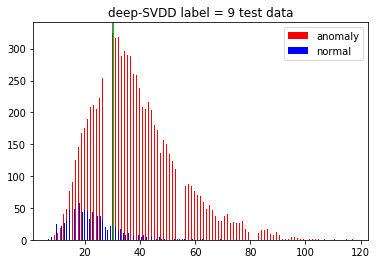

test label = 9 uncertain_img


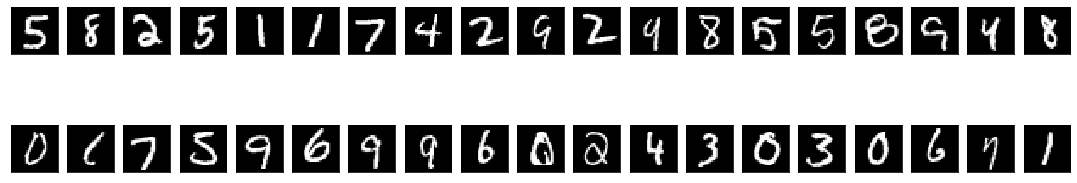

test label = 9 distance oder


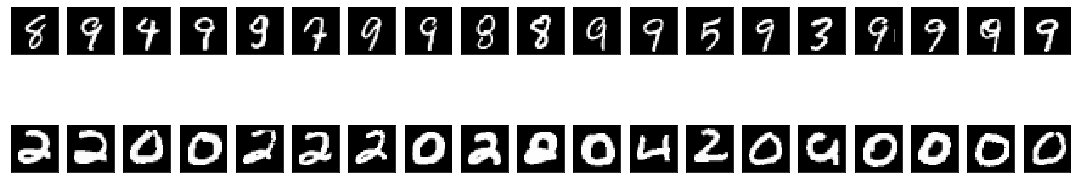

test label = 9 false_img


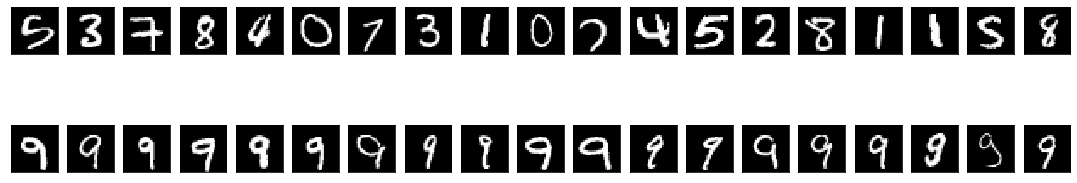

In [14]:
objective = 'deep-SVDD'
nu = 0.3
outlier_nu = 0.3
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)

